In [1]:
import pandas as pd 
import geopy
import seaborn as sns
import numpy as np
from geopy.geocoders import Nominatim
import pickle
import time
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # better and more arguments
from fbprophet import Prophet
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from fbprophet.diagnostics import cross_validation
from sklearn.tree import DecisionTreeRegressor
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
%matplotlib inline

In [3]:
def save_file(filename, savename):
    with open('{}.pkl'.format(savename), "wb") as output_file:
        pickle.dump(filename, output_file)
        print('File Saved')

In [2]:
def load_file(filename, open_name):
    with open('{}.pkl'.format(filename), "rb") as input_file:
        open_name = pickle.load(input_file)
        print('File Loaded')

### Import Data

In [1375]:
df_case = pd.read_csv('311_Cases.csv')

/Users/harmsway/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Modify Fields

In [ ]:
df_case['datetime'] = pd.to_datetime(df_case.Opened)

In [ ]:
df_case_dt = df_case.set_index('datetime')

In [ ]:
df_homeless = df_case_dt.loc[df_case_dt['Category'] == 'Homeless Concerns']

In [1381]:
df_homeless.count()

Police District        158409
CaseID                 158409
Opened                 158409
Closed                 156370
Updated                158409
Status                 158409
Status Notes            99566
Responsible Agency     158409
Category               158409
Request Type           158409
Request Details        158409
Address                158409
Supervisor District    158403
Neighborhood           157069
Latitude               158409
Longitude              158409
Point                  158409
Source                 158409
Media URL               39636
dtype: int64

In [18]:
save_file(df_homeless,'homeless_start')

File Saved


In [26]:
save_file(df_cop_call_homeless,'cop_homeless')

File Saved


In [1380]:
df_homeless.to_csv('homeless.csv')

In [264]:
with open('homeless_96.pkl', "rb") as input_file:
        df_homeless2 = pickle.load(input_file)

### EDA

In [255]:
df_homeless['Police District'] = df_homeless['Police District'].replace('BAYVIEW' ,'low_incident_area')

In [13]:
df_homeless.groupby(df_homeless.index.year).count()

CaseID  Opened  Closed  Updated  Status  Status Notes  \
datetime                                                          
2008        1880    1880    1880     1880    1880           731   
2009        6061    6061    6061     6061    6061            59   
2010        6075    6075    6075     6075    6075            28   
2011        5892    5892    5888     5892    5892            13   
2012        6711    6711    6702     6711    6711          4757   
2013        9570    9570    9556     9570    9570          9512   
2014       12630   12630   12613    12630   12630         12375   
2015       18216   18216   18210    18216   18216         17997   
2016       30008   30008   29788    30008   30008         25442   
2017       39448   39448   38816    39448   39448         18411   
2018       23894   23894   22746    23894   23894         11285   

          Responsible Agency  Category  Request Type  Request Details  \
datetime                                                                
2008                    1880      1880          1880             1880   
2009                    6061      6061          6061             6061   
2010                    6075      6075          6075             6075   
2011                    5892      5892          5892             5892   
2012                    6711      6711          6711             6711   
2013                    9570      9570          9570             9570   
2014                   12630     12630         12630            12630   
2015                   18216     18216         18216            18216   
2016                   30008     30008         30008            30008   
2017                   39448     39448         39448            39448   
2018                   23894     23894         23894            23894   

          Address  Supervisor District  Neighborhood  Police District  \
datetime                                                                
2008         1880                 1811          1868             1874   
2009         6061                 5676          5514             5676   
2010         6075                 5936          5780             5936   
2011         5892                 5723          5614             5723   
2012         6711                 6585          6444             6585   
2013         9570                 9450          9182             9449   
2014        12630                12446         12418            12443   
2015        18216                17948         17859            17947   
2016        30008                29871         29611            29867   
2017        39448                39397         39121            39109   
2018        23894                23876         23751            23863   

          Latitude  Longitude  Point  Source  Media URL  
datetime                                                 
2008          1880       1880   1811    1880          0  
2009          6061       6061   5676    6061          0  
2010          6075       6075   5937    6075          0  
2011          5892       5892   5723    5892          7  
2012          6711       6711   6585    6711          9  
2013          9570       9570   9450    9570        193  
2014         12630      12630  12446   12630       1642  
2015         18216      18216  17948   18216       5783  
2016         30008      30008  29875   30008       9996  
2017         39448      39448  39397   39448      13232  
2018         23894      23894  23877   23894       8909

In [600]:
df_homeless['Police District'].value_counts()

TENDERLOIN           38993
MISSION              36973
SOUTHERN             33941
low_incident_area    20033
NORTHERN             14520
CENTRAL              13949
Name: Police District, dtype: int64

In [288]:
df_homeless

CaseID                  Opened                  Closed  \
datetime                                                                       
2008-12-30 17:06:54   341687  12/30/2008 05:06:54 PM  12/31/2008 06:07:18 AM   
2008-12-30 12:15:08   341397  12/30/2008 12:15:08 PM  12/30/2008 07:07:10 PM   
2008-12-30 10:20:51   341240  12/30/2008 10:20:51 AM  12/30/2008 07:07:07 PM   
2008-12-30 10:06:28   341209  12/30/2008 10:06:28 AM  12/30/2008 11:07:07 AM   
2008-12-29 22:45:54   341018  12/29/2008 10:45:54 PM  12/30/2008 06:07:17 AM   
2008-12-29 17:32:46   340877  12/29/2008 05:32:46 PM  12/30/2008 06:07:13 AM   
2008-12-29 16:47:56   340823  12/29/2008 04:47:56 PM  12/30/2008 06:07:12 AM   
2008-12-29 16:30:23   340800  12/29/2008 04:30:23 PM  12/30/2008 06:07:22 AM   
2008-12-29 16:22:28   340790  12/29/2008 04:22:28 PM  12/30/2008 06:07:17 AM   
2008-12-29 16:05:00   340768  12/29/2008 04:05:00 PM  12/30/2008 06:07:22 AM   
2008-12-29 15:32:43   340733  12/29/2008 03:32:43 PM  12/30/2008 06:07:22 AM   
2008-12-29 11:18:38   340412  12/29/2008 11:18:38 AM  12/31/2008 06:07:15 AM   
2008-12-29 11:03:26   340393  12/29/2008 11:03:26 AM  12/30/2008 07:07:09 PM   
2008-12-18 13:23:05   334924  12/18/2008 01:23:05 PM  12/19/2008 08:07:03 PM   
2008-12-29 08:57:18   340272  12/29/2008 08:57:18 AM  12/30/2008 07:07:08 PM   
2008-12-28 17:12:15   340064  12/28/2008 05:12:15 PM  12/29/2008 06:07:13 AM   
2008-12-28 15:42:34   340012  12/28/2008 03:42:34 PM  12/29/2008 06:07:07 AM   
2008-12-28 15:40:27   340009  12/28/2008 03:40:27 PM  12/29/2008 06:07:07 AM   
2008-12-28 15:38:01   340005  12/28/2008 03:38:01 PM  12/29/2008 06:07:13 AM   
2008-12-28 15:22:37   339997  12/28/2008 03:22:37 PM  12/29/2008 06:07:09 AM   
2008-12-28 12:39:26   339904  12/28/2008 12:39:26 PM  12/29/2008 06:07:06 AM   
2008-12-28 11:36:01   339872  12/28/2008 11:36:01 AM  12/30/2008 06:07:07 AM   
2008-12-28 11:34:39   339871  12/28/2008 11:34:39 AM  12/29/2008 06:07:08 AM   
2008-12-28 11:33:14   339870  12/28/2008 11:33:14 AM  12/31/2008 06:07:18 AM   
2008-12-28 10:34:07   339843  12/28/2008 10:34:07 AM  12/31/2008 06:07:07 AM   
2008-12-27 17:39:41   339705  12/27/2008 05:39:41 PM  12/29/2008 06:07:06 AM   
2008-12-27 17:34:44   339703  12/27/2008 05:34:44 PM  12/29/2008 06:07:05 AM   
2008-12-27 17:00:50   339688  12/27/2008 05:00:50 PM  12/31/2008 06:07:14 AM   
2008-12-27 16:42:54   339671  12/27/2008 04:42:54 PM  12/31/2008 06:07:07 AM   
2008-12-27 16:28:41   339654  12/27/2008 04:28:41 PM  12/31/2008 06:07:06 AM   
...                      ...                     ...                     ...   
2018-06-24 17:23:00  9179735  06/24/2018 05:23:00 PM  06/24/2018 06:52:00 PM   
2018-06-24 17:41:00  9179806  06/24/2018 05:41:00 PM  06/24/2018 10:10:19 PM   
2018-06-24 17:44:00  9179815  06/24/2018 05:44:00 PM  06/24/2018 07:02:00 PM   
2018-06-24 18:04:38  9179877  06/24/2018 06:04:38 PM  06/24/2018 07:42:03 PM   
2018-06-24 18:28:00  9179943  06/24/2018 06:28:00 PM  06/24/2018 10:10:15 PM   
2017-11-01 16:31:00  8215193  11/01/2017 04:31:00 PM  11/14/2017 02:55:00 PM   
2018-06-24 18:59:01  9180035  06/24/2018 06:59:01 PM  06/24/2018 08:38:41 PM   
2018-06-24 19:01:00  9180044  06/24/2018 07:01:00 PM  06/24/2018 07:33:00 PM   
2018-06-24 19:46:07  9180164  06/24/2018 07:46:07 PM  06/24/2018 08:42:25 PM   
2018-06-24 20:11:11  9180255  06/24/2018 08:11:11 PM  06/24/2018 10:23:33 PM   
2018-06-24 20:13:15  9180261  06/24/2018 08:13:15 PM  06/24/2018 10:47:44 PM   
2018-06-24 20:30:00  9180304  06/24/2018 08:30:00 PM  06/24/2018 10:10:23 PM   
2018-06-24 21:37:02  9180450  06/24/2018 09:37:02 PM  06/24/2018 11:13:46 PM   
2018-06-24 22:56:20  9180550  06/24/2018 10:56:20 PM  06/24/2018 11:06:26 PM   
2017-11-04 11:09:00  8226488  11/04/2017 11:09:00 AM  11/05/2017 01:54:00 PM   
2017-11-04 16:40:00  8227728  11/04/2017 04:40:00 PM  11/14/2017 02:56:00 PM   
2017-11-05 14:13:00  8229863  11/05/2017 02:13:00 PM  11/05/2017 04:04:00 PM   
2017-11-10 16:28:00  8

In [310]:
df_homeless_day['datetime'] = df_homeless_day['datetime'].dt.date

In [589]:
graphgroupby = df_homeless2[['Police District','CaseID']]

In [591]:
graphgroupby = df_homeless2[['Police District','CaseID']]
#bx = graphgroupby.plot(kind='bar', title='Class Count', rot=0);
graphgroupby = (graphgroupby.groupby('Police District')
                .agg({'CaseID':'count'}))
graphgroupby = graphgroupby.sort_values('CaseID', ascending = False).reset_index(drop=True)
bx = graphgroupby.groupby('Police District').CaseID.count().plot.bar()
bx.set_title('Homeless Concerns by Neighborhood', fontsize=25)
bx.set_xlabel('Neighborhood', fontsize=25)
bx.set_ylabel('# of Calls', fontsize=25)
#bx.tick_params(labelsize=35)
bx.legend(loc=1, prop={'size': 10})
plt.xticks(rotation='vertical', fontsize=25)
plt.yticks(fontsize=25)
plt.savefig('CasebyNeigh.png')

KeyError: 'Police District'

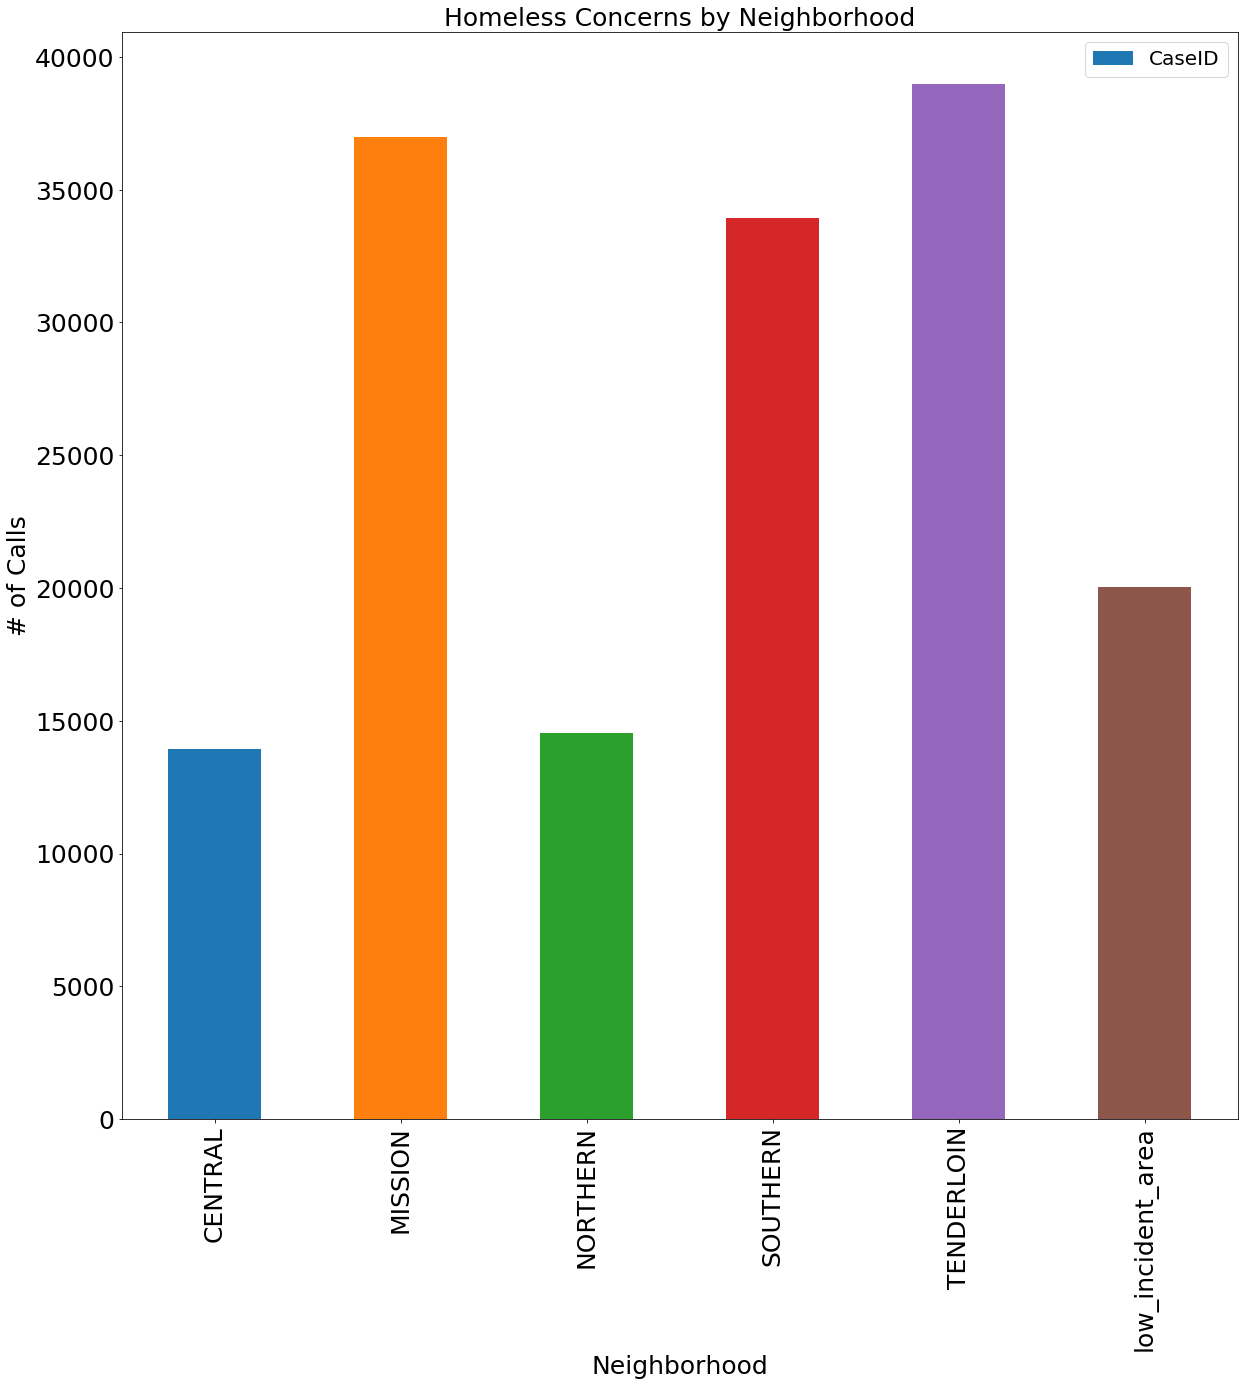

In [389]:
graphgroupby = df_homeless[['Police District','CaseID']]
#bx = graphgroupby.plot(kind='bar', title='Class Count', rot=0);
bx = graphgroupby.groupby('Police District').CaseID.count().plot.bar()
bx.set_title('Homeless Concerns by Neighborhood', fontsize=25)
bx.set_xlabel('Neighborhood', fontsize=25)
bx.set_ylabel('# of Calls', fontsize=25)
#bx.tick_params(labelsize=35)
bx.legend(loc=1, prop={'size': 20})
plt.xticks(rotation='vertical', fontsize=25)
plt.yticks(fontsize=25)
plt.savefig('CasebyNeighNew.png')

In [260]:
df_homeless['Police District'] = df_homeless['Police District'].replace('PARK' ,'low_incident_area')

In [249]:
df_homeless['Police District'] = map(lambda x: x.replace('BAYVIEW','low_incident_area'),df_homeless['Police District'])

In [268]:
df_homeless2.groupby('datetime','Police District').agg({'CaseID','count'})

ValueError: No axis named Police District for object type <class 'pandas.core.frame.DataFrame'>

In [252]:
df_homeless

Police District   CaseID                  Opened  \
datetime                                                                   
2008-12-30  <map object at 0x109eccba8>   341397  12/30/2008 12:15:08 PM   
2008-12-30  <map object at 0x109eccba8>   341240  12/30/2008 10:20:51 AM   
2008-12-30  <map object at 0x109eccba8>   341209  12/30/2008 10:06:28 AM   
2008-12-29  <map object at 0x109eccba8>   341018  12/29/2008 10:45:54 PM   
2008-12-29  <map object at 0x109eccba8>   340877  12/29/2008 05:32:46 PM   
2008-12-29  <map object at 0x109eccba8>   340823  12/29/2008 04:47:56 PM   
2008-12-29  <map object at 0x109eccba8>   340800  12/29/2008 04:30:23 PM   
2008-12-29  <map object at 0x109eccba8>   340790  12/29/2008 04:22:28 PM   
2008-12-29  <map object at 0x109eccba8>   340768  12/29/2008 04:05:00 PM   
2008-12-29  <map object at 0x109eccba8>   340733  12/29/2008 03:32:43 PM   
2008-12-29  <map object at 0x109eccba8>   340412  12/29/2008 11:18:38 AM   
2008-12-29  <map object at 0x109eccba8>   340393  12/29/2008 11:03:26 AM   
2008-12-29  <map object at 0x109eccba8>   340272  12/29/2008 08:57:18 AM   
2008-12-28  <map object at 0x109eccba8>   340064  12/28/2008 05:12:15 PM   
2008-12-28  <map object at 0x109eccba8>   340012  12/28/2008 03:42:34 PM   
2008-12-28  <map object at 0x109eccba8>   340009  12/28/2008 03:40:27 PM   
2008-12-28  <map object at 0x109eccba8>   340005  12/28/2008 03:38:01 PM   
2008-12-28  <map object at 0x109eccba8>   339997  12/28/2008 03:22:37 PM   
2008-12-28  <map object at 0x109eccba8>   339904  12/28/2008 12:39:26 PM   
2008-12-28  <map object at 0x109eccba8>   339872  12/28/2008 11:36:01 AM   
2008-12-28  <map object at 0x109eccba8>   339871  12/28/2008 11:34:39 AM   
2008-12-28  <map object at 0x109eccba8>   339870  12/28/2008 11:33:14 AM   
2008-12-28  <map object at 0x109eccba8>   339843  12/28/2008 10:34:07 AM   
2008-12-27  <map object at 0x109eccba8>   339705  12/27/2008 05:39:41 PM   
2008-12-27  <map object at 0x109eccba8>   339688  12/27/2008 05:00:50 PM   
2008-12-27  <map object at 0x109eccba8>   339671  12/27/2008 04:42:54 PM   
2008-12-27  <map object at 0x109eccba8>   339654  12/27/2008 04:28:41 PM   
2008-12-27  <map object at 0x109eccba8>   339542  12/27/2008 01:35:17 PM   
2008-12-27  <map object at 0x109eccba8>   339539  12/27/2008 01:28:53 PM   
2008-12-27  <map object at 0x109eccba8>   339521  12/27/2008 01:04:49 PM   
...                                 ...      ...                     ...   
2018-06-24  <map object at 0x109eccba8>  9179735  06/24/2018 05:23:00 PM   
2018-06-24  <map object at 0x109eccba8>  9179806  06/24/2018 05:41:00 PM   
2018-06-24  <map object at 0x109eccba8>  9179815  06/24/2018 05:44:00 PM   
2018-06-24  <map object at 0x109eccba8>  9179877  06/24/2018 06:04:38 PM   
2018-06-24  <map object at 0x109eccba8>  9179943  06/24/2018 06:28:00 PM   
2017-11-01  <map object at 0x109eccba8>  8215193  11/01/2017 04:31:00 PM   
2018-06-24  <map object at 0x109eccba8>  9180035  06/24/2018 06:59:01 PM   
2018-06-24  <map object at 0x109eccba8>  9180044  06/24/2018 07:01:00 PM   
2018-06-24  <map object at 0x109eccba8>  9180164  06/24/2018 07:46:07 PM   
2018-06-24  <map object at 0x109eccba8>  9180255  06/24/2018 08:11:11 PM   
2018-06-24  <map object at 0x109eccba8>  9180261  06/24/2018 08:13:15 PM   
2018-06-24  <map object at 0x109eccba8>  9180304  06/24/2018 08:30:00 PM   
2018-06-24  <map object at 0x109eccba8>  9180450  06/24/2018 09:37:02 PM   
2018-06-24  <map object at 0x109eccba8>  9180550  06/24/2018 10:56:20 PM   
2017-11-04  <map object at 0x109eccba8>  8226488  11/04/2017 11:09:00 AM   
2017-11-04  <map object at 0x109eccba8>  8227728  11/04/2017 04:40:00 PM   
2017-11-05  <map object at 0x109eccba8>  8229863  11/05/2017 02:13:00 PM   
2017-11-10  <map object at 0x109eccba8>  8253403  11/10/2017 04:28:00 PM   
2017-11-11  <map object at 0x109eccba8>  8255449  11/11/2017 11:14:00 AM   
2017-11-21  <map object at 0x109eccba8>  8297436  11/21/2017 03:45:00 PM

In [371]:
df_homeless_day = df_homeless_day[df_homeless_day['Police District'] != ' ']


In [414]:
graph = df_homeless_day[['CaseID']]

In [22]:
df_group_total = df_group_total.groupby('datetime').count()

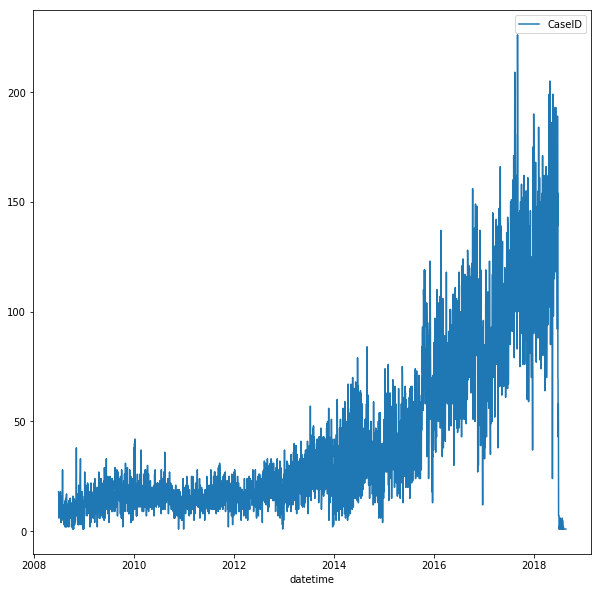

In [428]:
graph.plot(figsize=(10,10))

(0.5, 1.0)

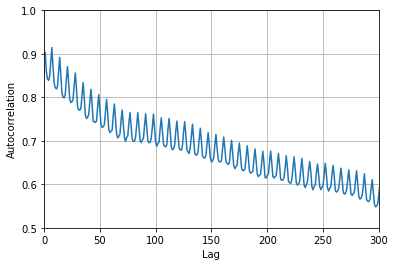

In [472]:
autocorrelation_plot(df_group_totak)
plt.xlim(0,300);
plt.ylim(0.5)

In [277]:
df_homeless_agg = (df_homeless.groupby(['Police District','datetime']).agg({'CaseID': 'count'}))

In [280]:
df_homeless_agg.reset_index(inplace=True)

In [282]:
df_homeless_agg = df_homeless_agg.pivot(index='datetime', columns='Police District', values='CaseID').fillna(0)

## ARIMA forecasting

In [98]:
from statsmodels.tsa.arima_model import ARMA, ARIMA

In [139]:
tenderloin_test = df_pivot.CaseID[['TENDERLOIN']][-30:]
tenderloin_train = df_pivot.CaseID[['TENDERLOIN']][:-30]

In [287]:
df_homeless_agg = df_homeless_agg[:-32]

In [110]:
df_pivot.CaseID['TENDERLOIN'].diff().std()
df_pivot.CaseID['TENDERLOIN'].diff().diff().std()
df_pivot.CaseID['TENDERLOIN'].diff().diff().diff().std()

20.928121783259304

In [289]:
df_homeless_agg

Police District  CENTRAL  MISSION  NORTHERN  SOUTHERN  TENDERLOIN  \
datetime                                                            
2008-07-01           0.0      2.0       6.0       4.0         4.0   
2008-07-02           1.0      2.0       4.0       4.0         3.0   
2008-07-03           0.0      3.0       1.0       2.0         3.0   
2008-07-04           0.0      1.0       2.0       0.0         2.0   
2008-07-05           0.0      1.0       1.0       1.0         4.0   
2008-07-06           0.0      3.0       0.0       1.0         1.0   
2008-07-07           2.0      2.0       3.0       1.0         2.0   
2008-07-08           0.0      4.0       1.0       1.0         3.0   
2008-07-09           1.0      3.0       1.0       5.0         2.0   
2008-07-10           1.0      2.0       1.0       8.0         1.0   
2008-07-11           2.0      7.0       1.0       2.0         4.0   
2008-07-12           1.0      1.0       1.0       3.0         0.0   
2008-07-13           2.0      1.0       1.0       1.0         2.0   
2008-07-14           1.0      5.0       0.0       6.0         3.0   
2008-07-15           0.0      6.0       3.0       3.0         3.0   
2008-07-16           0.0      3.0       1.0       6.0         1.0   
2008-07-17           0.0      2.0       2.0       7.0         1.0   
2008-07-18           0.0      1.0       0.0       0.0         2.0   
2008-07-19           0.0      1.0       0.0       1.0         0.0   
2008-07-20           1.0      1.0       1.0       0.0        10.0   
2008-07-21           3.0      3.0       1.0       1.0         2.0   
2008-07-22           1.0      1.0       5.0       2.0         3.0   
2008-07-23           1.0      4.0       0.0       5.0         6.0   
2008-07-24           0.0      2.0       1.0       1.0         3.0   
2008-07-25           0.0      2.0       0.0       5.0         2.0   
2008-07-26           1.0      3.0       0.0       1.0         2.0   
2008-07-27           0.0      3.0       0.0       3.0         4.0   
2008-07-28           1.0      4.0       2.0       2.0         1.0   
2008-07-29           0.0      2.0       0.0       6.0         0.0   
2008-07-30           1.0      3.0       3.0      10.0         6.0   
...                  ...      ...       ...       ...         ...   
2018-06-03          21.0     39.0      12.0      38.0         8.0   
2018-06-04          26.0     38.0      20.0      45.0        14.0   
2018-06-05          16.0     50.0      26.0      35.0        19.0   
2018-06-06          18.0     31.0      15.0      46.0        19.0   
2018-06-07          21.0     37.0      17.0      36.0        18.0   
2018-06-08          16.0     34.0      16.0      32.0        15.0   
2018-06-09          10.0     38.0      19.0      24.0        13.0   
2018-06-10          13.0     37.0      18.0      27.0        10.0   
2018-06-11          21.0     39.0      17.0      29.0        29.0   
2018-06-12          23.0     37.0      22.0      50.0        39.0   
2018-06-13          21.0     44.0      18.0      28.0        24.0   
2018-06-14          22.0     39.0      15.0      40.0        24.0   
2018-06-15          15.0     37.0      11.0      29.0        25.0   
2018-06-16          17.0     19.0      19.0      30.0         8.0   
2018-06-17          20.0     44.0      18.0      19.0        10.0   
2018-06-18          15.0     34.0      19.0      37.0        34.0   
2018-06-19          23.0     27.0      23.0      28.0        39.0   
2018-06-20          21.0     25.0      19.0      24.0        19.0   
2018-06-21          15.0     29.0      15.0      29.0        17.0   
2018-06-22          22.0     23.0      15.0      36.0        18.0   
2018-06-23          15.0     31.0      18.0      26.0        13.0   
2018-06-24          10.0     25.0      16.0      18.0         9.0   
2018-06-25          22.0     36.0      26.0      44.0        29.0   
2018-06-26          18.0     21.0      22.0      35.0        21.0   
2018-06-27          23.0     25.0      12.0      31.0        19.0  

In [538]:
ar_mission = ARIMA(df_train.MISSION,(14,1,2)).fit()

/Users/harmsway/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/harmsway/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


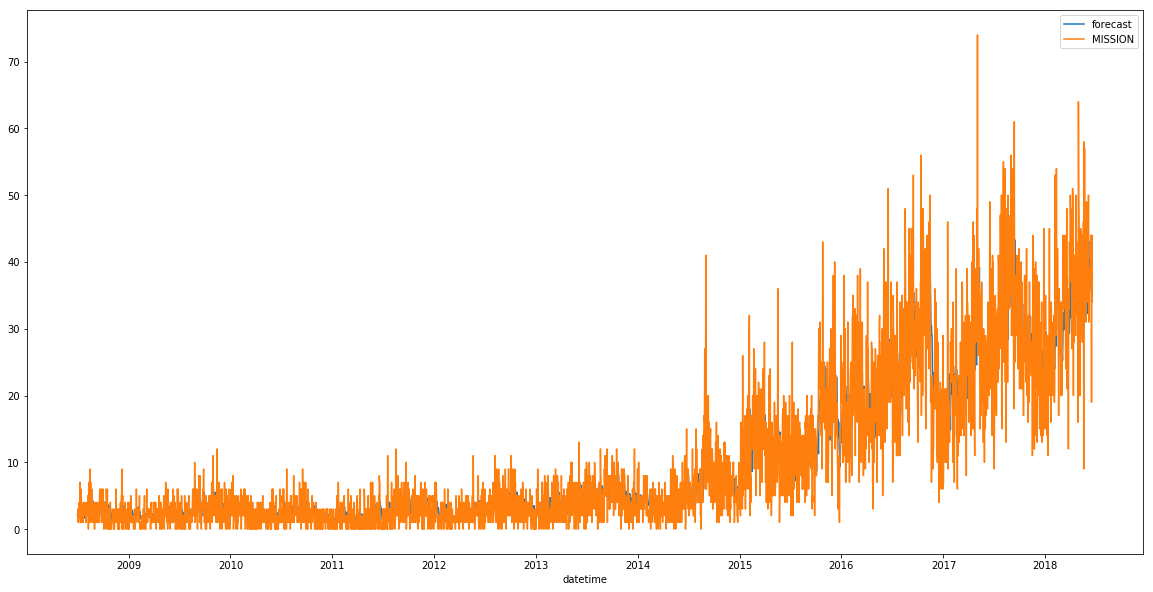

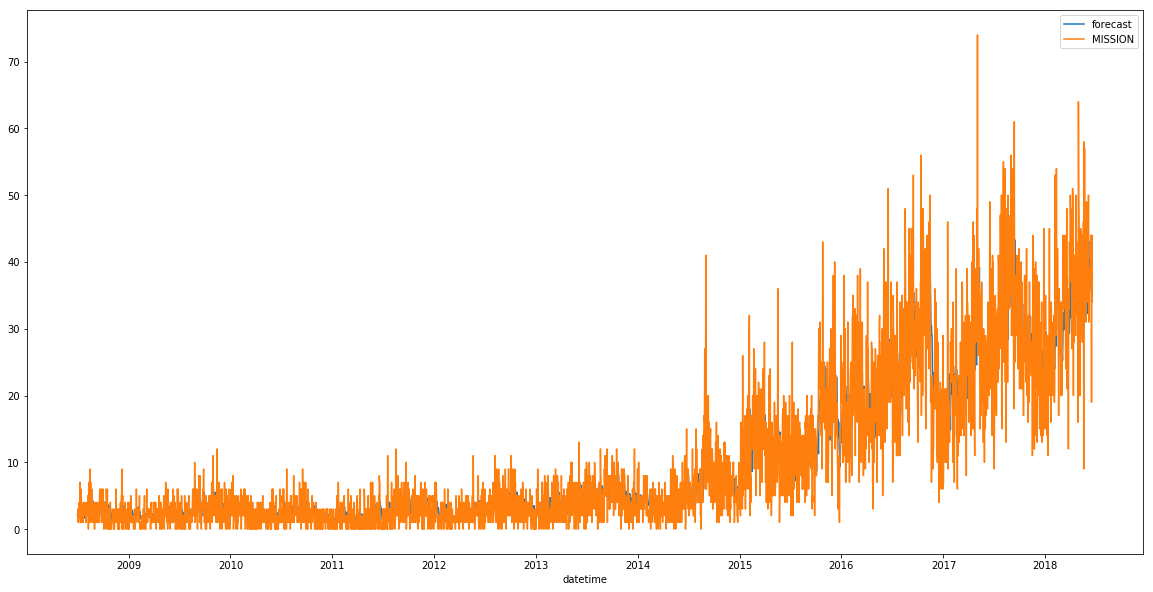

In [539]:
ar_mission.plot_predict()

Figure(1440x720)
Figure(1440x720)


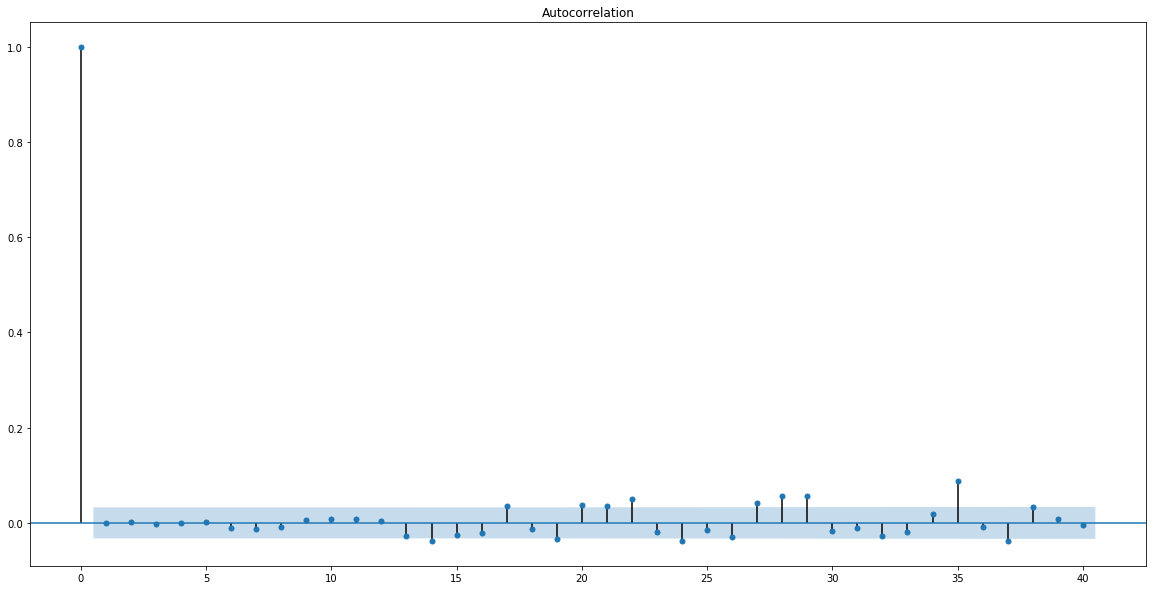

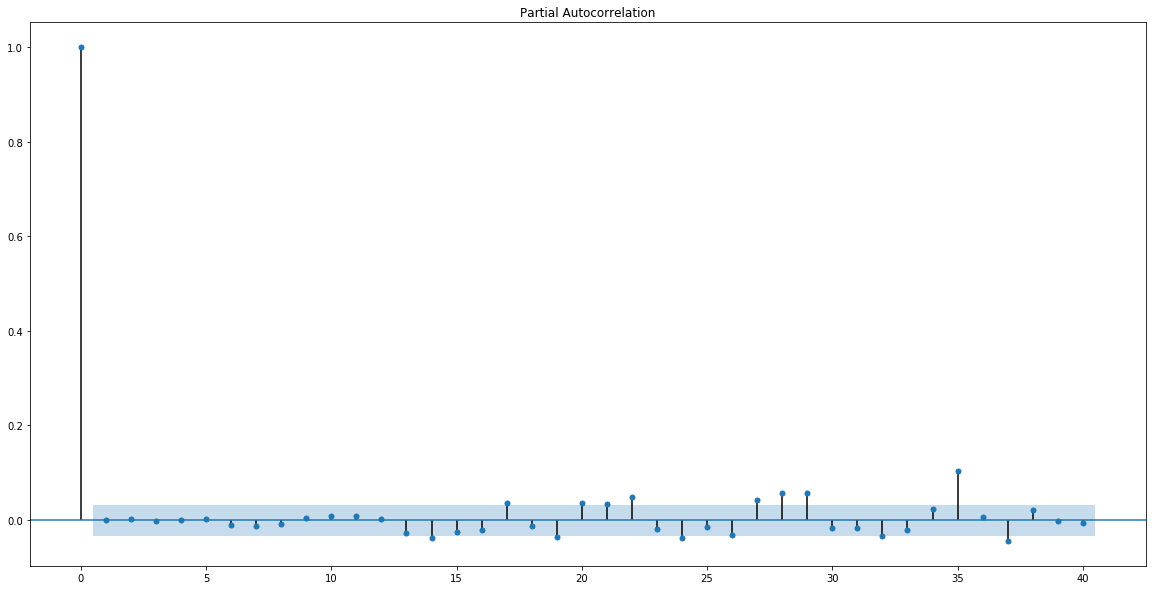

In [535]:
print(plot_acf(ar_mission.resid, lags=40)) # these are for non-stationary data, so we can see patterns, but generally ignore
print(plot_pacf(ar_mission.resid, lags=40))

Figure(1440x720)
Figure(1440x720)


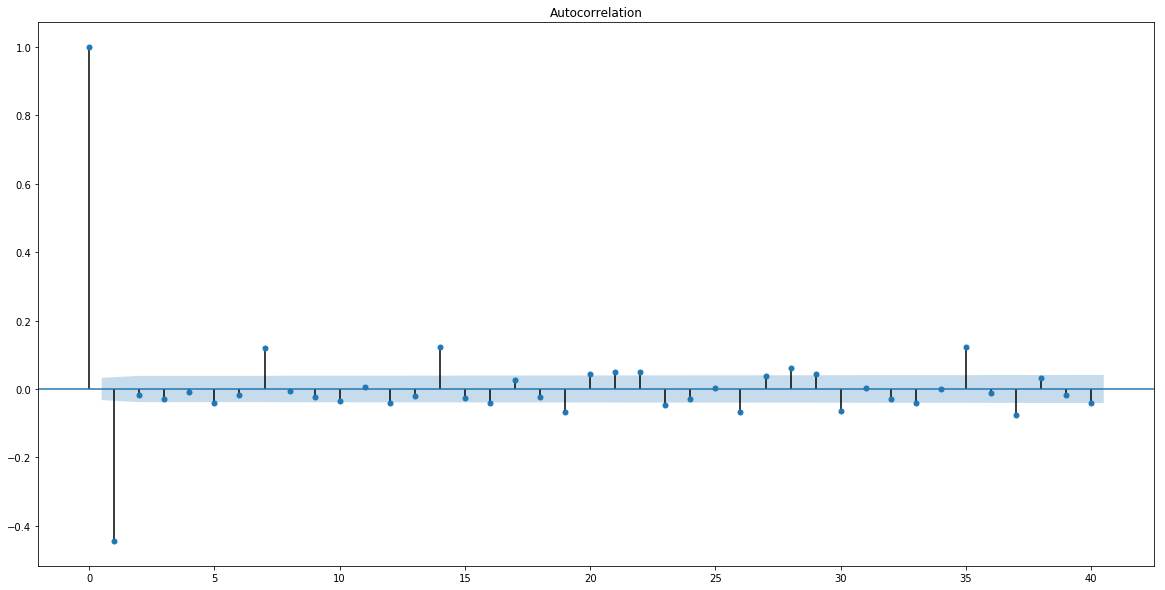

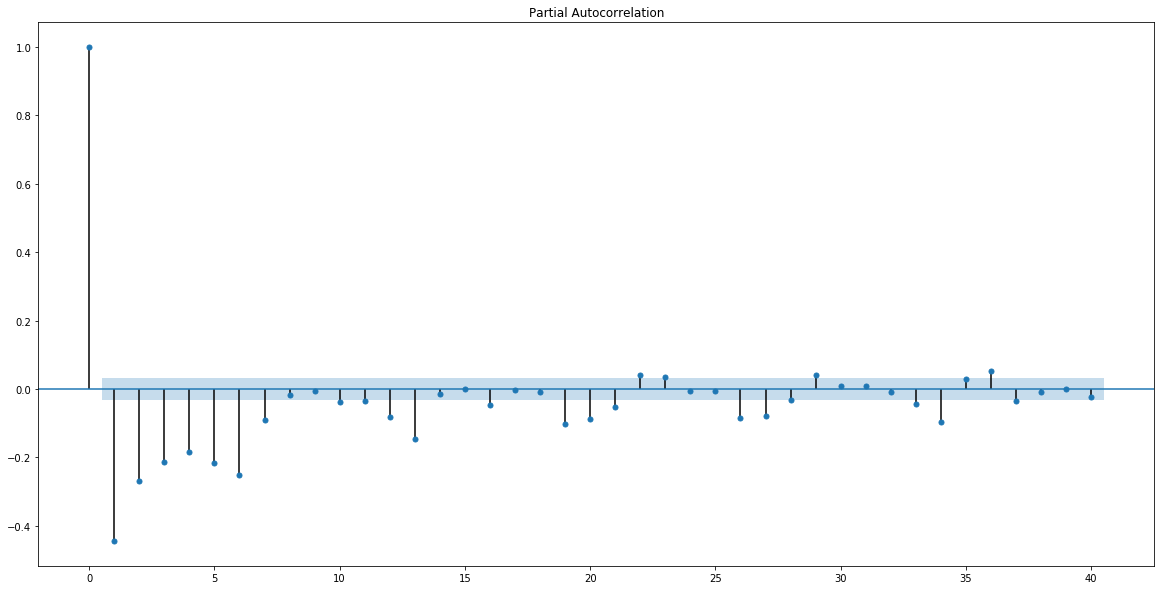

In [511]:
print(plot_acf(df_train.MISSION.diff()[1:], lags=40)) # these are for non-stationary data, so we can see patterns, but generally ignore
print(plot_pacf(df_train.MISSION.diff()[1:], lags=40))

In [171]:
ar1 = ARIMA(tenderloin_train,(6,1, 7)).fit()

/Users/harmsway/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/harmsway/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [151]:
ar1.predict('2018-06-02',2018-06-02

Police District  TENDERLOIN
datetime                   
2008-07-01              4.0
2008-07-02              3.0
2008-07-03              3.0
2008-07-04              2.0
2008-07-05              4.0
2008-07-06              1.0
2008-07-07              2.0
2008-07-08              3.0
2008-07-09              2.0
2008-07-10              1.0
2008-07-11              4.0
2008-07-12              0.0
2008-07-13              2.0
2008-07-14              3.0
2008-07-15              3.0
2008-07-16              1.0
2008-07-17              1.0
2008-07-18              2.0
2008-07-19              0.0
2008-07-20             10.0
2008-07-21              2.0
2008-07-22              3.0
2008-07-23              6.0
2008-07-24              3.0
2008-07-25              2.0
2008-07-26              2.0
2008-07-27              4.0
2008-07-28              1.0
2008-07-29              0.0
2008-07-30              6.0
...                     ...
2018-05-04             21.0
2018-05-05             10.0
2018-05-06             10.0
2018-05-07             40.0
2018-05-08             24.0
2018-05-09             24.0
2018-05-10             24.0
2018-05-11             25.0
2018-05-12             11.0
2018-05-13              9.0
2018-05-14             34.0
2018-05-15             41.0
2018-05-16             33.0
2018-05-17             26.0
2018-05-18             22.0
2018-05-19              4.0
2018-05-20             12.0
2018-05-21             28.0
2018-05-22             40.0
2018-05-23             43.0
2018-05-24             20.0
2018-05-25             28.0
2018-05-26              6.0
2018-05-27             19.0
2018-05-28             11.0
2018-05-29             33.0
2018-05-30             31.0
2018-05-31             24.0
2018-06-01             23.0
2018-06-02             14.0

[3619 rows x 1 columns]

In [173]:
output = ar1.forecast(30)

In [174]:
yhat = output[0]

In [175]:
yhat[0]

13.717904746560295

In [199]:
df_pivot

CaseID                                                    \
Police District BAYVIEW CENTRAL INGLESIDE MISSION NORTHERN  PARK RICHMOND   
datetime                                                                    
2008-07-01          1.0     0.0       0.0     2.0      6.0   0.0      1.0   
2008-07-02          1.0     1.0       1.0     2.0      4.0   0.0      1.0   
2008-07-03          0.0     0.0       0.0     3.0      1.0   1.0      0.0   
2008-07-04          1.0     0.0       0.0     1.0      2.0   0.0      0.0   
2008-07-05          0.0     0.0       0.0     1.0      1.0   0.0      0.0   
2008-07-06          1.0     0.0       1.0     3.0      0.0   0.0      0.0   
2008-07-07          0.0     2.0       1.0     2.0      3.0   0.0      0.0   
2008-07-08          0.0     0.0       0.0     4.0      1.0   0.0      2.0   
2008-07-09          0.0     1.0       0.0     3.0      1.0   1.0      0.0   
2008-07-10          0.0     1.0       1.0     2.0      1.0   1.0      1.0   
2008-07-11          0.0     2.0       0.0     7.0      1.0   1.0      0.0   
2008-07-12          0.0     1.0       0.0     1.0      1.0   1.0      0.0   
2008-07-13          0.0     2.0       0.0     1.0      1.0   0.0      0.0   
2008-07-14          1.0     1.0       1.0     5.0      0.0   0.0      0.0   
2008-07-15          0.0     0.0       0.0     6.0      3.0   2.0      0.0   
2008-07-16          0.0     0.0       0.0     3.0      1.0   2.0      0.0   
2008-07-17          1.0     0.0       0.0     2.0      2.0   0.0      0.0   
2008-07-18          0.0     0.0       0.0     1.0      0.0   3.0      0.0   
2008-07-19          0.0     0.0       0.0     1.0      0.0   1.0      0.0   
2008-07-20          0.0     1.0       2.0     1.0      1.0   0.0      0.0   
2008-07-21          0.0     3.0       0.0     3.0      1.0   0.0      0.0   
2008-07-22          0.0     1.0       0.0     1.0      5.0   0.0      0.0   
2008-07-23          0.0     1.0       0.0     4.0      0.0   0.0      0.0   
2008-07-24          1.0     0.0       0.0     2.0      1.0   0.0      0.0   
2008-07-25          0.0     0.0       0.0     2.0      0.0   0.0      0.0   
2008-07-26          0.0     1.0       0.0     3.0      0.0   0.0      0.0   
2008-07-27          0.0     0.0       0.0     3.0      0.0   0.0      0.0   
2008-07-28          0.0     1.0       1.0     4.0      2.0   0.0      1.0   
2008-07-29          0.0     0.0       0.0     2.0      0.0   0.0      0.0   
2008-07-30          2.0     1.0       0.0     3.0      3.0   3.0      0.0   
...                 ...     ...       ...     ...      ...   ...      ...   
2018-06-03          0.0    21.0       3.0    39.0     12.0   3.0      4.0   
2018-06-04          7.0    26.0       3.0    38.0     20.0   8.0      7.0   
2018-06-05          2.0    16.0       2.0    50.0     26.0  10.0      7.0   
2018-06-06          7.0    18.0       1.0    31.0     15.0   5.0      5.0   
2018-06-07          5.0    21.0       5.0    37.0     17.0   7.0      5.0   
2018-06-08          2.0    16.0       2.0    34.0     16.0   2.0      3.0   
2018-06-09          5.0    10.0       5.0    38.0     19.0   9.0      6.0   
2018-06-10          5.0    13.0       5.0    37.0     18.0   8.0      7.0   
2018-06-11         13.0    21.0       3.0    39.0     17.0   7.0      5.0   
2018-06-12          7.0    23.0       2.0    37.0     22.0   5.0      4.0   
2018-06-13          7.0    21.0       8.0    44.0     18.0   4.0      3.0   
2018-06-14          5.0    22.0       3.0    39.0     15.0   7.0      2.0   
2018-06-15          4.0    15.0       2.0    37.0     11.0  11.0      8.0   
2018-06-16          3.0    17.0       3.0    19.0     19.0  15.0      0.0   
2018-06-17          5.0    20.0       4.0    44.0     18.0  10.0      3.0   
2018-06-18          6.0    15.0      10.0    34.0     19.0   8.0      6.0   
2018-06-19          9.0    23.0       0.0    27.0     23.0   5.0      6.0   
2018-06-20          5.0    21.0       3.0    25.0     19.0   4.0      3.0   
2018-06-21   

In [546]:
ar_pred_dict = {}
ar_actual_dict = {}
ar_rmse_dict = {}
for neigh in ['MISSION']:
    df = pd.DataFrame(df_homeless_agg[neigh])
    df_train = df[:-14]
    df_test = df[-14:]
    ar = ARIMA(df_train.MISSION,(15,1,2)).fit()
    output = ar.forecast(14)[1]
    predicted = []
    actual_l = []
    print(neigh)
    for x in range(14):
        predict = output[x]
        predicted.append(predict)
        actual = df_homeless_agg[neigh][x]
        actual_l.append(actual)
        print('predicted {}, actual {}'.format(predict,actual))
    ar_pred_dict[neigh] = predicted
    avg = sum(actual_l)/len(actual_l)
    ar_actual_dict[neigh] = actual_l
    rm = rmse(actual_l,predicted,print_val=False)
    mae = mean_absolute_error(actual_l,predicted)
    print('MAE {}'.format(mae))
    accuracy = (1 - (rm/avg))*100
    print('Accruacy {}'.format(accuracy))


/Users/harmsway/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/harmsway/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


MISSION
predicted 5.046401442898728, actual 2.0
predicted 5.138175932754411, actual 2.0
predicted 5.1891670219537716, actual 3.0
predicted 5.2134350532132085, actual 1.0
predicted 5.233630503617265, actual 1.0
predicted 5.247337470439572, actual 3.0
predicted 5.28384746705878, actual 2.0
predicted 5.413631931359803, actual 4.0
predicted 5.479372253803282, actual 3.0
predicted 5.502684914718285, actual 2.0
predicted 5.509623130799994, actual 7.0
predicted 5.518519471941326, actual 1.0
predicted 5.52306864940553, actual 1.0
predicted 5.545382460246245, actual 5.0
MAE 2.9160736744721585
Accruacy -19.32865343624499


In [570]:
ar_mission.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:              D.MISSION   No. Observations:                 3634
Model:                ARIMA(14, 1, 2)   Log Likelihood              -11039.958
Method:                       css-mle   S.D. of innovations              5.047
Date:                Tue, 18 Sep 2018   AIC                          22115.917
Time:                        08:30:39   BIC                          22227.482
Sample:                             1   HQIC                         22155.657
                                                                              
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0092      0.003      2.679      0.007       0.002       0.016
ar.L1.D.MISSION      0.1544      0.116      1.335      0.182      -0.072       0.381
ar.L2.D.MISSION      0.1038      0.027      3.842      0.000       0.051       0.157
ar.L3.D.MISSION      0.0474      0.020      2.348      0.019       0.008       0.087
ar.L4.D.MISSION      0.0417      0.018      2.355      0.019       0.007       0.076
ar.L5.D.MISSION      0.0261      0.017      1.501      0.133      -0.008       0.060
ar.L6.D.MISSION      0.0764      0.017      4.457      0.000       0.043       0.110
ar.L7.D.MISSION      0.1699      0.019      8.790      0.000       0.132       0.208
ar.L8.D.MISSION      0.0546      0.027      1.988      0.047       0.001       0.108
ar.L9.D.MISSION     -0.0146      0.018     -0.807      0.420      -0.050       0.021
ar.L10.D.MISSION    -0.0358      0.017     -2.109      0.035      -0.069      -0.003
ar.L11.D.MISSION    -0.0058      0.017     -0.335      0.737      -0.040       0.028
ar.L12.D.MISSION    -0.0185      0.017     -1.094      0.274      -0.052       0.015
ar.L13.D.MISSION     0.0299      0.017      1.766      0.077      -0.003       0.063
ar.L14.D.MISSION     0.1251      0.018      7.115      0.000       0.091       0.160
ma.L1.D.MISSION     -0.9633      0.116     -8.286      0.000      -1.191      -0.735
ma.L2.D.MISSION     -0.0268      0.115     -0.234      0.815      -0.251       0.198
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             1.0473           -0.0000j            1.0473           -0.0000
AR.2             1.1014           -0.4781j            1.2007           -0.0652
AR.3             1.1014           +0.4781j            1.2007            0.0652
AR.4             0.6897           -0.8457j            1.0913           -0.1411
AR.5             0.6897           +0.8457j            1.0913            0.1411
AR.6             0.2503           -1.1766j            1.2030           -0.2166
AR.7             0.2503           +1.1766j            1.2030            0.2166
AR.8            -0.2510           -1.1117j            1.1397           -0.2853
AR.9            -0.2510           +1.1117j            1.1397            0.2853
AR.10           -0.7582           -0.9153j            1.1885           -0.3601
AR.11           -0.7582           +0.9153j            1.1885            0.3601
AR.12           -1.0666           -0.4876j            1.1728           -0.4318
AR.13           -1.0666           +0.4876j            1.1728            0.4318
AR.14           -1.2170           -0.0000j            1.2170           -0.5000
MA.1             1.0097           +0.0000j            1.0097            0.0000
MA.2           -36.9418           +0.000

(733043.1, 737044.9)

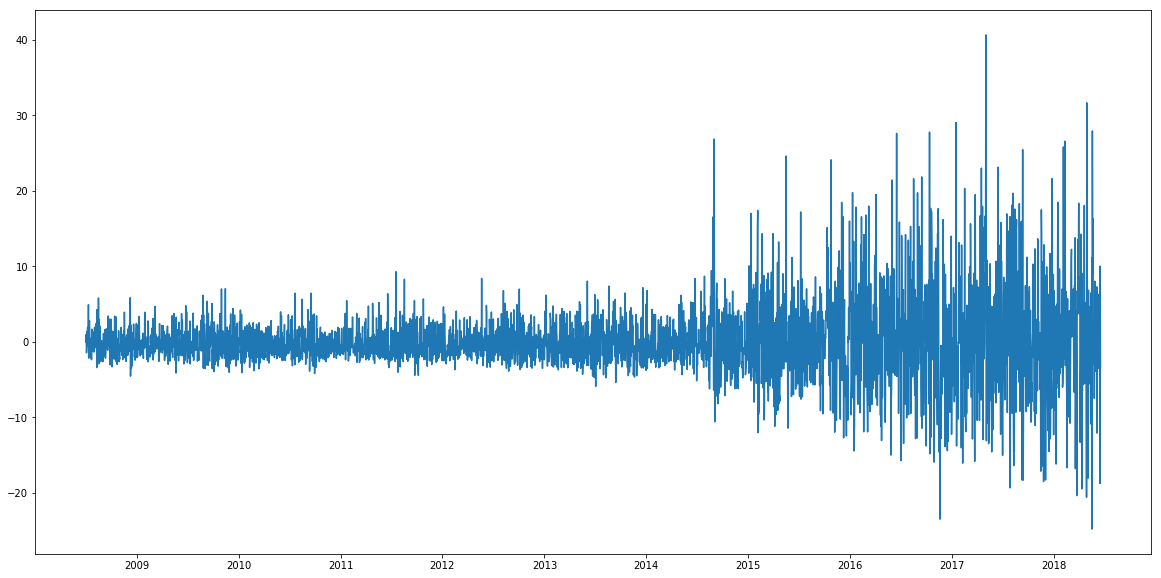

In [565]:
plt.plot(ar_mission.resid)
plt.xlim()

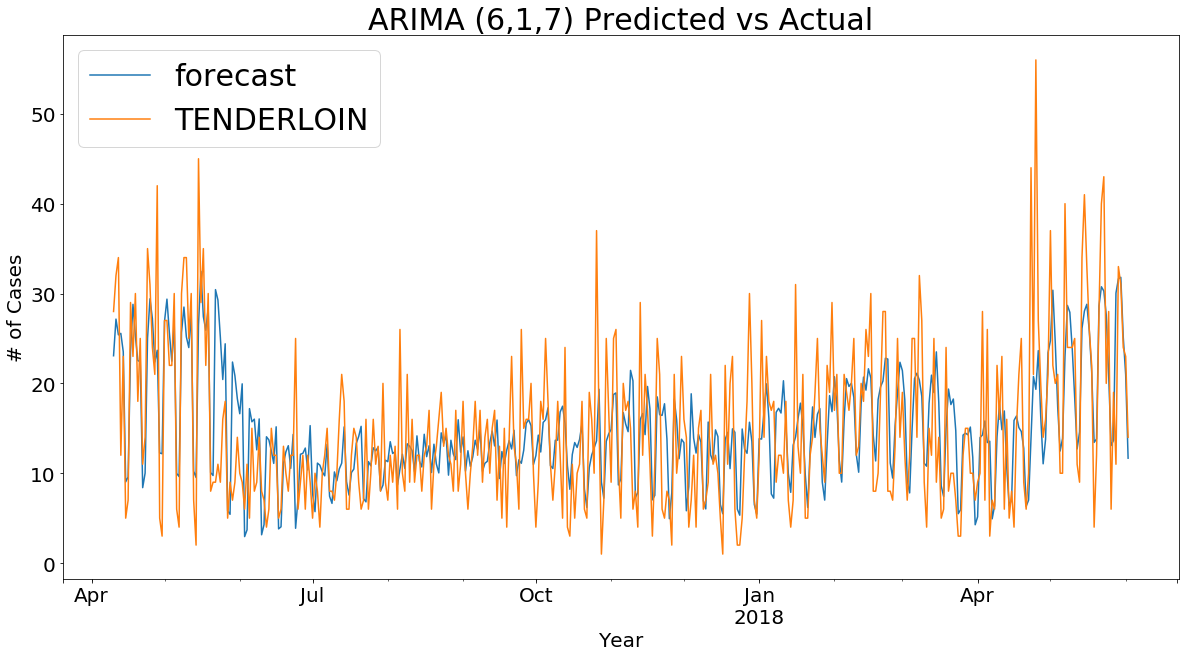

In [465]:
ar1.plot_predict(3200)
plt.title('ARIMA (6,1,7) Predicted vs Actual', fontsize=30)
plt.xlabel('Year', fontsize=20)
plt.ylabel("# of Cases", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc=2, prop={'size': 30})
plt.savefig('tenderloingraph.png')

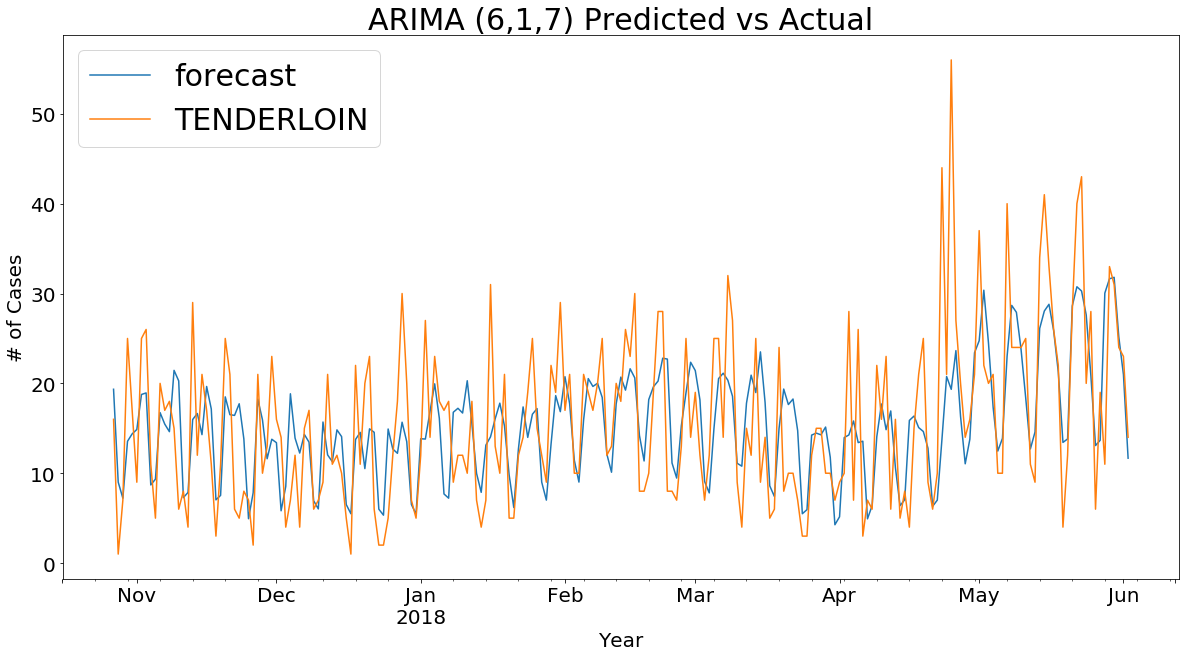

In [551]:
ar1.plot_predict(3400)
plt.title('ARIMA (6,1,7) Predicted vs Actual', fontsize=30)
plt.xlabel('Year', fontsize=20)
plt.ylabel("# of Cases", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc=2, prop={'size': 30})
plt.savefig('tenderloingraph.png')

In [447]:
avg_dict = {}
for neigh in df_homeless_agg.columns:
    df = pd.DataFrame(df_homeless_agg[neigh])
    df_train = df[:-14]
    df_test = df[-14:]
    avg = sum(df_test[neigh])/len(df_test[neigh])
    avg_dict[neigh] = avg
    

In [444]:
x = sum(df_test['low_incident_area'])/len(df_test['low_incident_area'])

In [448]:
avg_dict

{'CENTRAL': 14.571428571428571,
 'MISSION': 22.571428571428573,
 'NORTHERN': 14.214285714285714,
 'SOUTHERN': 24.0,
 'TENDERLOIN': 15.357142857142858,
 'low_incident_area': 17.785714285714285}

In [450]:
save_file(df_homeless_agg,'li_area')


File Saved


## Regression Models

In [407]:
scaler = StandardScaler()
models = [('Lasso', Lasso),
          ('Ridge', Ridge),
          ('Linear', LinearRegression), 
          ('Random Forest', RandomForestRegressor),
          ('tree', DecisionTreeRegressor),
         ('gradient', GradientBoostingRegressor)]

params_choices = [
    {
    'alpha': [500, 800, 1000, 1300, 2000, 5000],
    'max_iter': [1000, 2000, 4000]
    },
    {
    'alpha': [500, 800, 1000, 1300, 2000, 5000],
    'max_iter': [1000, 2000, 4000],
    },
    {
        
    },
    {
        'max_depth': [2, 5, 10, 100, 500],
        'criterion': ['mae']
    },
    {
        'max_depth': [2, 5, 6,7,8, 10, 15, 25, 30, 35],
        'criterion': ['mae']
    },
    {
        'n_estimators': [2, 5, 10 , 20],
        'max_depth': [2, 5, 6,7,8, 10, 15, 25, 30, 35]
    }]

grids = {}
for area in df_homeless_agg.columns:
    df = pd.DataFrame(df_homeless_agg[area])
    df.reset_index(inplace=True)
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['DaysSince0'] = ((df['datetime'] - min(df['datetime'])).dt.days)**2
    df['dayweek'] = df['datetime'].dt.dayofweek
    df['month'] = df['datetime'].dt.month
    df['lag_6'] = df[area].shift(6)
    df['ma_7'] = df[area].rolling(7).mean()
    df.fillna(0, inplace=True)
    df.drop('datetime',inplace=True, axis=1)
    X = df.iloc[:,1:]
    y = df.iloc[:,0]
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3)
    for model_info, params in zip(models, params_choices):
        name, model = model_info
        grid = GridSearchCV(model(), params, scoring='neg_mean_absolute_error', cv=8)
        grid.fit(X_train, y_train)
        s = f"{name} {area}: best score: {grid.best_score_}, test score {grid.score(X_test,y_test)}"
        print(s)
        grids[name] = grid

Lasso CENTRAL: best score: -3.7345207365220943, test score -3.8858930212434246
Ridge CENTRAL: best score: -1.5980253797165789, test score -1.645073875088527
Linear CENTRAL: best score: -1.4677408363687041, test score -1.5056540859073175
Random Forest CENTRAL: best score: -1.4872161315583399, test score -1.4795890410958905
tree CENTRAL: best score: -1.5268206734534064, test score -1.5424657534246575
gradient CENTRAL: best score: -1.5659565927846066, test score -1.6545679815408703
Lasso MISSION: best score: -9.42574850065085, test score -9.179041560735598
Ridge MISSION: best score: -3.3014610365058576, test score -3.2019275337270194
Linear MISSION: best score: -2.95555801742069, test score -2.8618088726905206
Random Forest MISSION: best score: -2.933437744714174, test score -2.846940639269406
tree MISSION: best score: -3.0794831636648397, test score -2.9269406392694064
gradient MISSION: best score: -3.126861306269244, test score -3.0337071308165235
Lasso NORTHERN: best score: -3.69774636

Figure(1440x720)
Figure(1440x720)


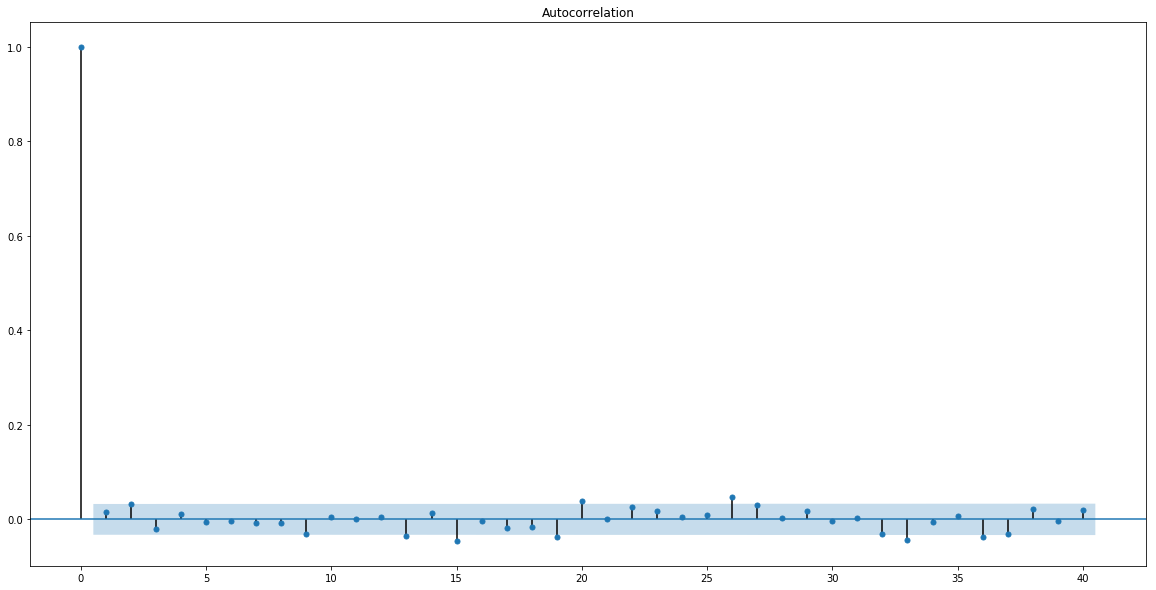

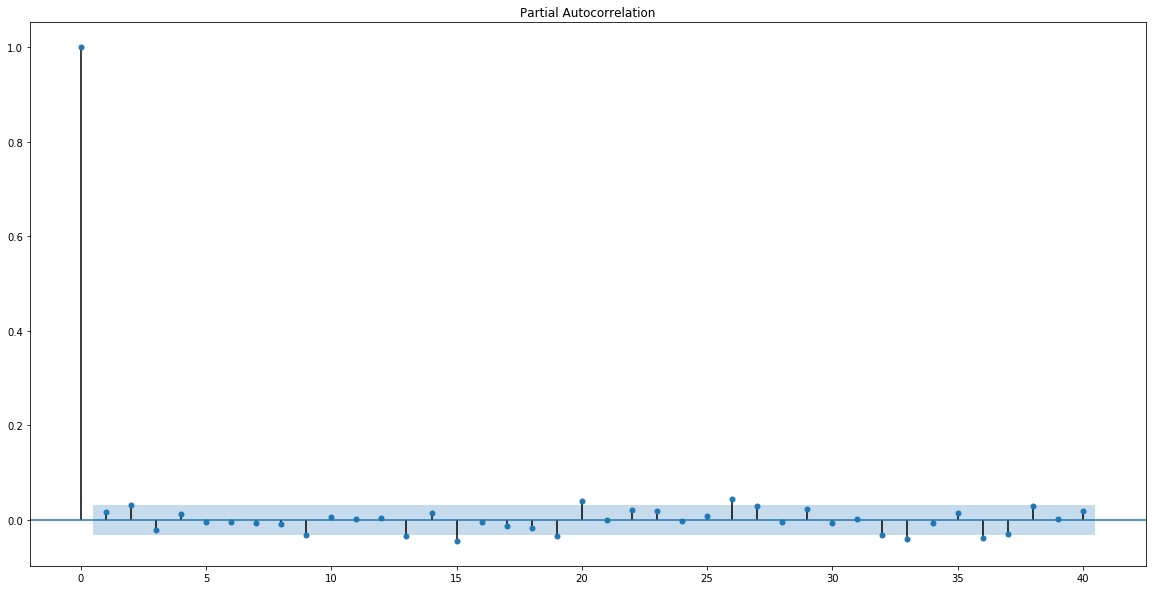

In [423]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 10

print(plot_acf(ar1.resid, lags=40)) # these are for non-stationary data, so we can see patterns, but generally ignore
print(plot_pacf(ar1.resid, lags=40))

In [131]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 25, 6

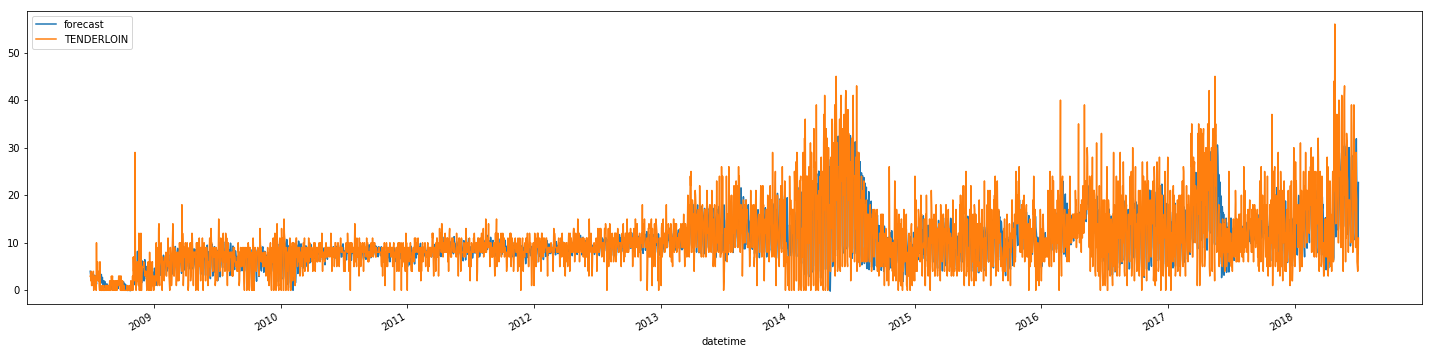

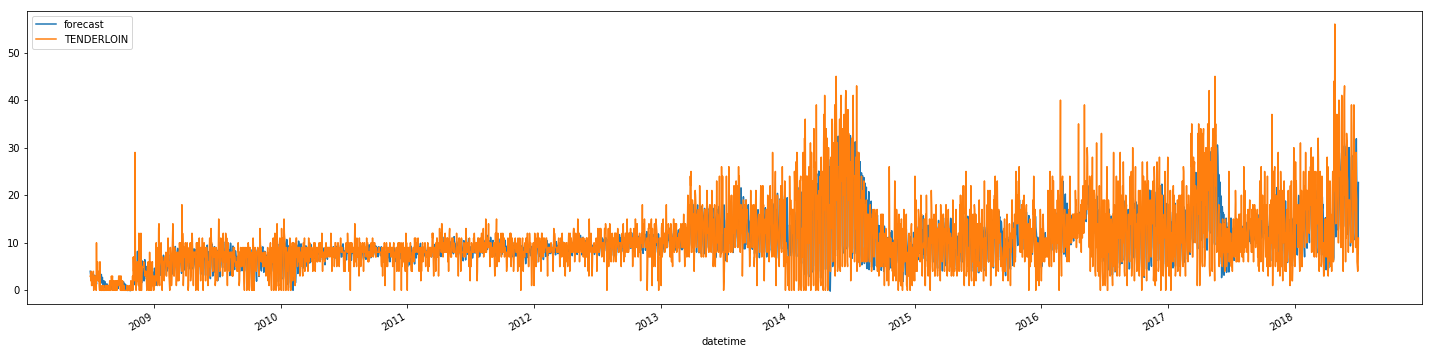

In [115]:
df_pivot.CaseID[['TENDERLOIN']]

Police District  TENDERLOIN
datetime                   
2008-07-01              4.0
2008-07-02              3.0
2008-07-03              3.0
2008-07-04              2.0
2008-07-05              4.0
2008-07-06              1.0
2008-07-07              2.0
2008-07-08              3.0
2008-07-09              2.0
2008-07-10              1.0
2008-07-11              4.0
2008-07-12              0.0
2008-07-13              2.0
2008-07-14              3.0
2008-07-15              3.0
2008-07-16              1.0
2008-07-17              1.0
2008-07-18              2.0
2008-07-19              0.0
2008-07-20             10.0
2008-07-21              2.0
2008-07-22              3.0
2008-07-23              6.0
2008-07-24              3.0
2008-07-25              2.0
2008-07-26              2.0
2008-07-27              4.0
2008-07-28              1.0
2008-07-29              0.0
2008-07-30              6.0
...                     ...
2018-06-03              8.0
2018-06-04             14.0
2018-06-05             19.0
2018-06-06             19.0
2018-06-07             18.0
2018-06-08             15.0
2018-06-09             13.0
2018-06-10             10.0
2018-06-11             29.0
2018-06-12             39.0
2018-06-13             24.0
2018-06-14             24.0
2018-06-15             25.0
2018-06-16              8.0
2018-06-17             10.0
2018-06-18             34.0
2018-06-19             39.0
2018-06-20             19.0
2018-06-21             17.0
2018-06-22             18.0
2018-06-23             13.0
2018-06-24              9.0
2018-06-25             29.0
2018-06-26             21.0
2018-06-27             19.0
2018-06-28              6.0
2018-06-29              5.0
2018-06-30              4.0
2018-07-01              5.0
2018-07-02             11.0

[3649 rows x 1 columns]

In [242]:
ar1 = ARIMA(df_group_total['CaseID'], (6,1, 7)).fit()

/Users/harmsway/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/harmsway/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/harmsway/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


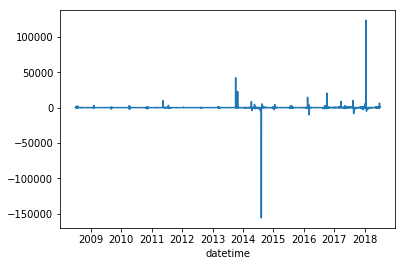

In [243]:
ar1.resid.plot()

Figure(432x288)
Figure(432x288)


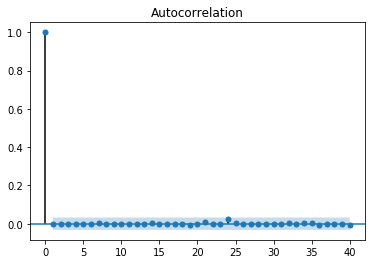

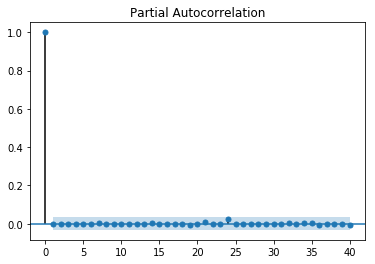

In [245]:
print(plot_acf(ar1.resid, lags=40)) # spikes and patterns show model hasn't captured variance
print(plot_pacf(ar1.resid, lags=40))

In [184]:
df_group_total

CaseID
datetime          
2008-07-01      18
2008-07-02      17
2008-07-03      10
2008-07-04       6
2008-07-05       8
2008-07-06       7
2008-07-07      11
2008-07-08      11
2008-07-09      13
2008-07-10      17
2008-07-11      17
2008-07-12       7
2008-07-13       7
2008-07-14      17
2008-07-15      18
2008-07-16      13
2008-07-17      14
2008-07-18       6
2008-07-19       4
2008-07-20      15
2008-07-21      11
2008-07-22      12
2008-07-23      16
2008-07-24       9
2008-07-25       9
2008-07-26       7
2008-07-27      10
2008-07-28      12
2008-07-29       8
2008-07-30      28
...            ...
2018-06-03     132
2018-06-04     171
2018-06-05     168
2018-06-06     149
2018-06-07     153
2018-06-08     123
2018-06-09     136
2018-06-10     133
2018-06-11     164
2018-06-12     193
2018-06-13     162
2018-06-14     160
2018-06-15     147
2018-06-16     118
2018-06-17     134
2018-06-18     170
2018-06-19     163
2018-06-20     125
2018-06-21     122
2018-06-22     132
2018-06-23     114
2018-06-24      92
2018-06-25     189
2018-06-26     139
2018-06-27     154
2018-06-28      70
2018-06-29      69
2018-06-30      43
2018-07-01      58
2018-07-02      49

[3649 rows x 1 columns]

In [246]:
def forecast(dataframe, model):
    print(len(dataframe))
    fig, ax = plt.subplots()
    ax = dataframe.plot(ax=ax)
    plt.plot(dataframe.index, dataframe, 'c', lw=1, alpha=0.8, zorder=-1, label="Actual")
    fig = model.plot_predict(ax=ax, plot_insample=False)

3649


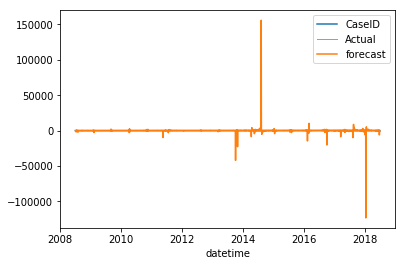

In [247]:
forecast(df_group_total, ar1)

In [185]:
ar2 = ARIMA(df_group_total['CaseID'], (6,1, 6)).fit()

/Users/harmsway/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/harmsway/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/harmsway/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Figure(432x288)
Figure(432x288)


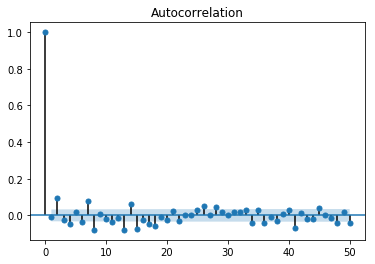

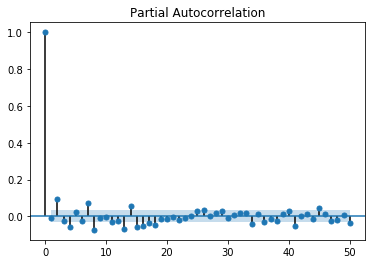

In [186]:
print(plot_acf(ar2.resid, lags=50)) # spikes and patterns show model hasn't captured variance
print(plot_pacf(ar2.resid, lags=50))

3649


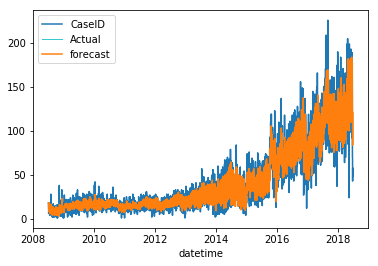

In [248]:
forecast(df_group_total, ar2)

In [297]:
ar2.forecast(steps=100)[1]

array([12.25799349, 12.74376377, 12.91738309, 13.06639894, 13.22564829,
       13.37004066, 13.57321597, 13.84986498, 14.07599974, 14.214301  ,
       14.35177233, 14.4932042 , 14.62875887, 14.81074517, 15.06934761,
       15.27324465, 15.40387707, 15.52751641, 15.6616423 , 15.78428059,
       15.95674175, 16.1928944 , 16.38643884, 16.50522134, 16.62335439,
       16.74592202, 16.86361134, 17.02202872, 17.24730695, 17.42578979,
       17.5399819 , 17.64853345, 17.76669726, 17.87535759, 18.02783706,
       18.23732723, 18.40914596, 18.51479446, 18.61983424, 18.72960925,
       18.83512812, 18.97735854, 19.17951431, 19.34020592, 19.44279343,
       19.54065224, 19.64748958, 19.74621034, 19.88436931, 20.07460273,
       20.23061148, 20.32663962, 20.42205567, 20.52242966, 20.61898687,
       20.74922358, 20.93412967, 21.08146872, 21.17529744, 21.26506311,
       21.36333362, 21.45452923, 21.58178256, 21.75726579, 21.90110428,
       21.9896883 , 22.07764336, 22.17073606, 22.26034871, 22.38

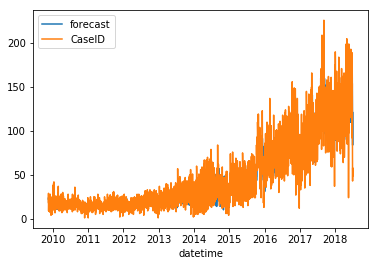

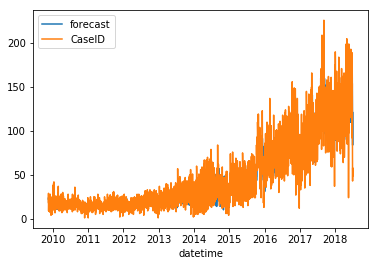

In [311]:
ar2.plot_predict(start=500)

In [288]:
ar2.forecast(100)[0][0]

117.49154956977645

In [250]:
ar3 = ARIMA(df_group_total['CaseID'], (6,1, 8)).fit()

/Users/harmsway/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/harmsway/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/harmsway/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/harmsway/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


3649


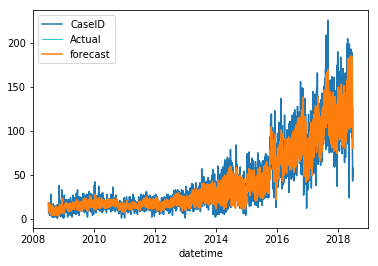

In [251]:
forecast(df_group_total,ar3)

In [260]:
ar2.summary()

/Users/harmsway/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/arima_model.py:1455: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
/Users/harmsway/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/harmsway/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/harmsway/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.CaseID   No. Observations:                 3648
Model:                 ARIMA(6, 1, 6)   Log Likelihood              -14335.930
Method:                       css-mle   S.D. of innovations             12.258
Date:                Mon, 10 Sep 2018   AIC                          28699.860
Time:                        10:50:09   BIC                          28786.687
Sample:                             1   HQIC                         28730.783
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0221   2.24e-06   9878.436      0.000       0.022       0.022
ar.L1.D.CaseID    -0.0861   2.58e-06  -3.33e+04      0.000      -0.086      -0.086
ar.L2.D.CaseID    -0.6295        nan        nan        nan         nan         nan
ar.L3.D.CaseID    -0.5664        nan        nan        nan         nan         nan
ar.L4.D.CaseID    -0.1365   3.62e-07  -3.77e+05      0.000      -0.136      -0.136
ar.L5.D.CaseID    -0.9719        nan        nan        nan         nan         nan
ar.L6.D.CaseID     0.1046   1.35e-05   7736.531      0.000       0.105       0.105
ma.L1.D.CaseID    -0.6296      0.012    -51.482      0.000      -0.654      -0.606
ma.L2.D.CaseID     0.4558      0.007     70.033      0.000       0.443       0.469
ma.L3.D.CaseID     0.0945      0.010      9.844      0.000       0.076       0.113
ma.L4.D.CaseID    -0.3341      0.009    -37.546      0.000      -0.351      -0.317
ma.L5.D.CaseID     0.7969      0.007    120.848      0.000       0.784       0.810
ma.L6.D.CaseID    -0.7877      0.013    -61.421      0.000      -0.813      -0.763
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0067           -0.0000j            1.0067           -0.5000
AR.2           -0.2221           -0.9750j            1.0000           -0.2856
AR.3           -0.2221           +0.9750j            1.0000            0.2856
AR.4            0.6231           -0.7821j            1.0000           -0.1429
AR.5            0.6231           +0.7821j            1.0000            0.1429
AR.6            9.4945           -0.0000j            9.4945           -0.0000
MA.1           -1.0081           -0.0000j            1.0081           -0.5000
MA.2           -0.2252           -0.9832j            1.0086           -0.2858
MA.3           -0.2252           +0.9832j            1.0086            0.2858
MA.4            0.6349           -0.7925j            1.0154           -0.1425
MA.5            0.6349           +0.7925j            1.0154            0.1425
MA.6            1.2005           -0.0000j            1.2005           -0.0000
-----------------------------------------------------------------------------
"""

Figure(432x288)
Figure(432x288)


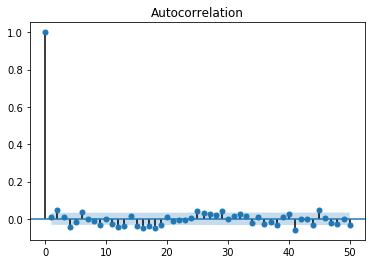

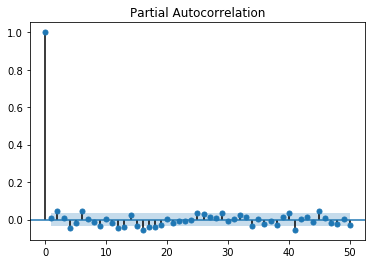

In [228]:
print(plot_acf(ar3.resid, lags=50)) # spikes and patterns show model hasn't captured variance
print(plot_pacf(ar3.resid, lags=50))

In [ ]:
preds = ar3.plot_predict.(3500,3670,dynamic=False, ax=ax, plot_insample=False)

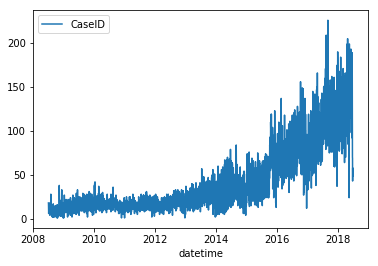

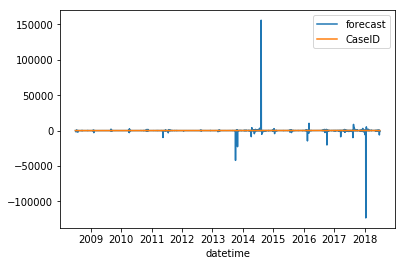

In [239]:
fig, ax = plt.subplots()
ax = df_group_total.plot(ax=ax)
fig = ar1.plot_predict()

In [ ]:
fig, ax = plt.subplots()e
ax = df_group_total.plot(ax=ax)
fig = ar3.plot_predict(3500,3670,dynamic=False, ax=ax, plot_insample=False)
plt.xlim(736850,736900)

In [ ]:
df_group_total = df_group_total[:-23]

In [98]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):   
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    timeseries.dropna(inplace=True)
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [110]:
df_reg = df_regress[['datetime','CaseID']]

In [ ]:
print(len(dfs))
fig, ax = plt.subplots()
ax = dfs[:120].plot(ax=ax)
plt.plot(dfs.index[120:200], dfs[120:200], 'c', lw=1, alpha=0.8, zorder=-1, label="Actual")
fig = arima210.plot_predict(120, 200,ax=ax, plot_insample=False)

In [195]:
ar4 = ARIMA(df_group_total['CaseID'], (7,1, 6)).fit()

/Users/harmsway/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/harmsway/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Figure(432x288)
Figure(432x288)


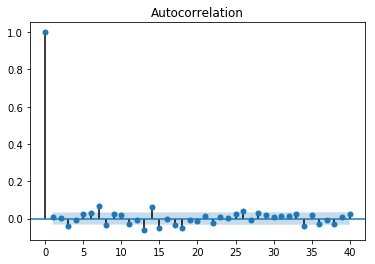

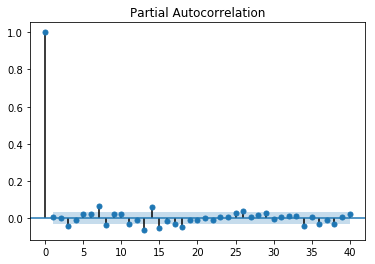

In [198]:
print(plot_acf(ar4.resid, lags=40)) # spikes and patterns show model hasn't captured variance
print(plot_pacf(ar4.resid, lags=40))

In [225]:
df_group_total

CaseID
datetime          
2008-07-01      18
2008-07-02      17
2008-07-03      10
2008-07-04       6
2008-07-05       8
2008-07-06       7
2008-07-07      11
2008-07-08      11
2008-07-09      13
2008-07-10      17
2008-07-11      17
2008-07-12       7
2008-07-13       7
2008-07-14      17
2008-07-15      18
2008-07-16      13
2008-07-17      14
2008-07-18       6
2008-07-19       4
2008-07-20      15
2008-07-21      11
2008-07-22      12
2008-07-23      16
2008-07-24       9
2008-07-25       9
2008-07-26       7
2008-07-27      10
2008-07-28      12
2008-07-29       8
2008-07-30      28
...            ...
2018-06-03     132
2018-06-04     171
2018-06-05     168
2018-06-06     149
2018-06-07     153
2018-06-08     123
2018-06-09     136
2018-06-10     133
2018-06-11     164
2018-06-12     193
2018-06-13     162
2018-06-14     160
2018-06-15     147
2018-06-16     118
2018-06-17     134
2018-06-18     170
2018-06-19     163
2018-06-20     125
2018-06-21     122
2018-06-22     132
2018-06-23     114
2018-06-24      92
2018-06-25     189
2018-06-26     139
2018-06-27     154
2018-06-28      70
2018-06-29      69
2018-06-30      43
2018-07-01      58
2018-07-02      49

[3649 rows x 1 columns]

In [229]:
test_stationarity(df_group_total['CaseID'].diff())

Results of Dickey-Fuller Test:
Test Statistic                -1.562089e+01
p-value                        1.732479e-28
#Lags Used                     2.800000e+01
Number of Observations Used    3.619000e+03
Critical Value (1%)           -3.432158e+00
Critical Value (5%)           -2.862339e+00
Critical Value (10%)          -2.567195e+00
dtype: float64


In [230]:
df_group_total

CaseID
datetime          
2008-07-01      18
2008-07-02      17
2008-07-03      10
2008-07-04       6
2008-07-05       8
2008-07-06       7
2008-07-07      11
2008-07-08      11
2008-07-09      13
2008-07-10      17
2008-07-11      17
2008-07-12       7
2008-07-13       7
2008-07-14      17
2008-07-15      18
2008-07-16      13
2008-07-17      14
2008-07-18       6
2008-07-19       4
2008-07-20      15
2008-07-21      11
2008-07-22      12
2008-07-23      16
2008-07-24       9
2008-07-25       9
2008-07-26       7
2008-07-27      10
2008-07-28      12
2008-07-29       8
2008-07-30      28
...            ...
2018-06-03     132
2018-06-04     171
2018-06-05     168
2018-06-06     149
2018-06-07     153
2018-06-08     123
2018-06-09     136
2018-06-10     133
2018-06-11     164
2018-06-12     193
2018-06-13     162
2018-06-14     160
2018-06-15     147
2018-06-16     118
2018-06-17     134
2018-06-18     170
2018-06-19     163
2018-06-20     125
2018-06-21     122
2018-06-22     132
2018-06-23     114
2018-06-24      92
2018-06-25     189
2018-06-26     139
2018-06-27     154
2018-06-28      70
2018-06-29      69
2018-06-30      43
2018-07-01      58
2018-07-02      49

[3649 rows x 1 columns]

In [241]:
df_group_total.CaseID.sort_values(ascending=True)

datetime
2008-10-19      1
2011-01-01      1
2008-10-12      1
2012-12-25      1
2009-01-01      1
2008-12-25      1
2010-11-25      1
2009-02-16      2
2008-09-13      2
2008-09-14      2
2009-04-10      2
2008-08-30      2
2011-11-24      2
2008-10-04      2
2009-10-13      2
2008-08-17      2
2008-08-24      2
2013-12-25      2
2008-10-18      2
2008-11-26      3
2014-01-01      3
2008-10-26      3
2008-11-27      3
2008-12-24      3
2012-12-23      3
2008-08-10      3
2008-10-11      3
2008-08-31      3
2008-10-05      3
2008-11-20      3
             ... 
2018-06-05    168
2018-06-18    170
2017-08-09    171
2018-03-08    171
2018-06-04    171
2018-05-03    171
2017-12-28    175
2018-04-23    176
2018-05-21    180
2018-05-08    180
2017-08-21    181
2017-08-16    181
2018-01-03    181
2018-05-15    182
2018-02-07    184
2018-05-07    186
2018-05-16    186
2018-06-25    189
2018-05-23    189
2018-01-02    190
2017-08-18    190
2017-09-07    190
2018-05-29    193
2018-06-12    193
2

In [261]:
import statsmodels.api as sm

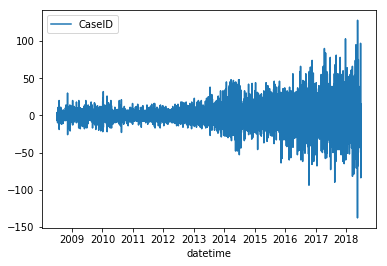

In [314]:
df_group_total.diff().plot()

Figure(432x288)
Figure(432x288)


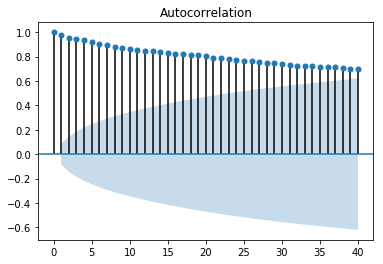

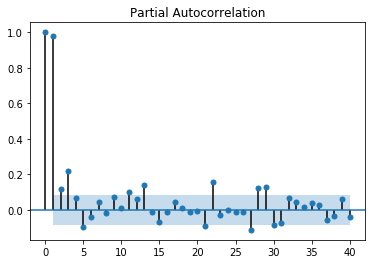

In [327]:
print(plot_acf(dfw.CaseID, lags=40)) # these are for non-stationary data, so we can see patterns, but generally ignore
print(plot_pacf(dfw.CaseID, lags=40))

Figure(432x288)
Figure(432x288)


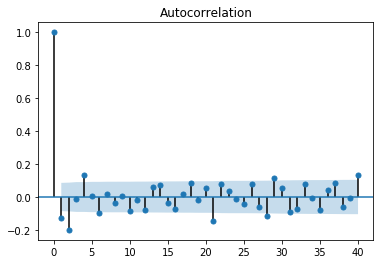

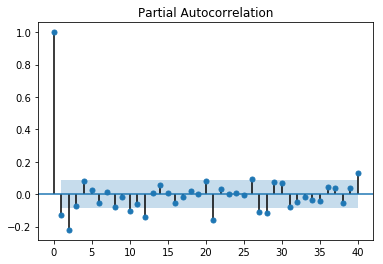

In [338]:
print(plot_acf(dfw.CaseID.diff()[1:], lags=40)) # these are for non-stationary data, so we can see patterns, but generally ignore
print(plot_pacf(dfw.CaseID.diff()[1:], lags=40))

In [354]:
arw1 = ARIMA(dfw['CaseID'], (21,1, 0)).fit()

Figure(432x288)
Figure(432x288)


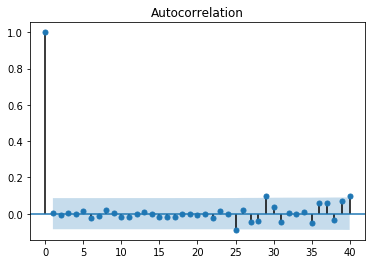

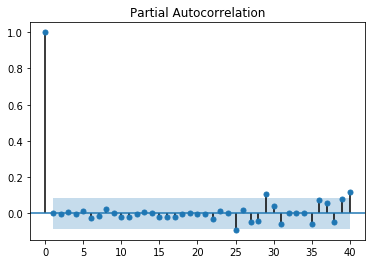

In [356]:
print(plot_acf(arw1.resid, lags=40)) # these are for non-stationary data, so we can see patterns, but generally ignore
print(plot_pacf(arw1.resid, lags=40))

## Prophet

In [375]:
m = Prophet()

In [371]:
df_prophet = df_prophet.rename(columns={'datetime': 'ds', 'CaseID':'y' })

In [372]:
df

ds    y
0    2008-07-01   18
1    2008-07-02   17
2    2008-07-03   10
3    2008-07-04    6
4    2008-07-05    8
5    2008-07-06    7
6    2008-07-07   11
7    2008-07-08   11
8    2008-07-09   13
9    2008-07-10   17
10   2008-07-11   17
11   2008-07-12    7
12   2008-07-13    7
13   2008-07-14   17
14   2008-07-15   18
15   2008-07-16   13
16   2008-07-17   14
17   2008-07-18    6
18   2008-07-19    4
19   2008-07-20   15
20   2008-07-21   11
21   2008-07-22   12
22   2008-07-23   16
23   2008-07-24    9
24   2008-07-25    9
25   2008-07-26    7
26   2008-07-27   10
27   2008-07-28   12
28   2008-07-29    8
29   2008-07-30   28
...         ...  ...
3619 2018-06-03  132
3620 2018-06-04  171
3621 2018-06-05  168
3622 2018-06-06  149
3623 2018-06-07  153
3624 2018-06-08  123
3625 2018-06-09  136
3626 2018-06-10  133
3627 2018-06-11  164
3628 2018-06-12  193
3629 2018-06-13  162
3630 2018-06-14  160
3631 2018-06-15  147
3632 2018-06-16  118
3633 2018-06-17  134
3634 2018-06-18  170
3635 2018-06-19  163
3636 2018-06-20  125
3637 2018-06-21  122
3638 2018-06-22  132
3639 2018-06-23  114
3640 2018-06-24   92
3641 2018-06-25  189
3642 2018-06-26  139
3643 2018-06-27  154
3644 2018-06-28   70
3645 2018-06-29   69
3646 2018-06-30   43
3647 2018-07-01   58
3648 2018-07-02   49

[3649 rows x 2 columns]

In [376]:
proph1 = m.fit(df_prophet)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/harmsway/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [377]:
proph1.changepoints

117    2008-10-26
233    2009-02-20
350    2009-06-18
467    2009-10-13
584    2010-02-07
700    2010-06-03
817    2010-09-28
934    2011-01-25
1050   2011-05-22
1167   2011-09-16
1284   2012-01-11
1401   2012-05-07
1517   2012-08-31
1634   2012-12-26
1751   2013-04-22
1868   2013-08-17
1984   2013-12-11
2101   2014-04-07
2218   2014-08-02
2334   2014-11-26
2451   2015-03-23
2568   2015-07-18
2685   2015-11-12
2801   2016-03-07
2918   2016-07-02
Name: ds, dtype: datetime64[ns]

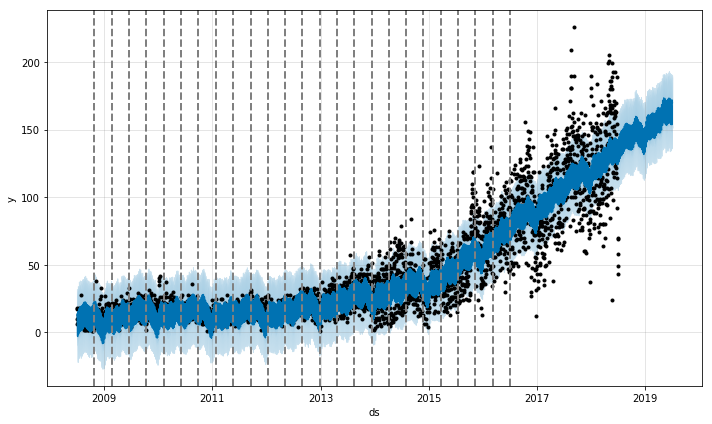

In [378]:
future = proph1.make_future_dataframe(periods=366)
forecast = proph1.predict(future)
fig = proph1.plot(forecast)
for cp in proph1.changepoints:
    plt.axvline(cp, c='gray', ls='--', lw=2)

In [384]:
forecast = proph1.predict(future)

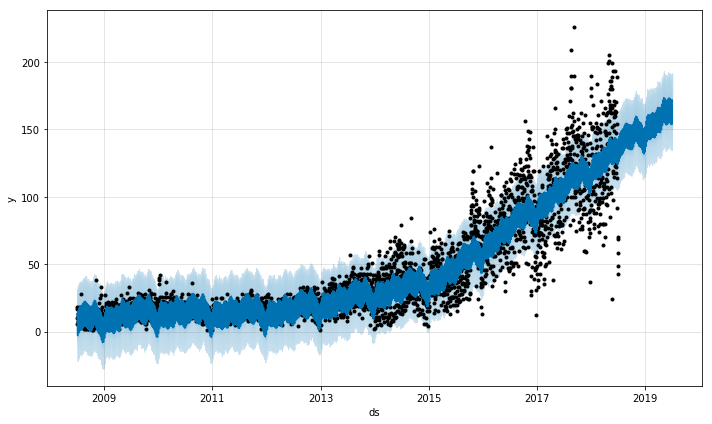

In [385]:
fig1 = proph1.plot(forecast)

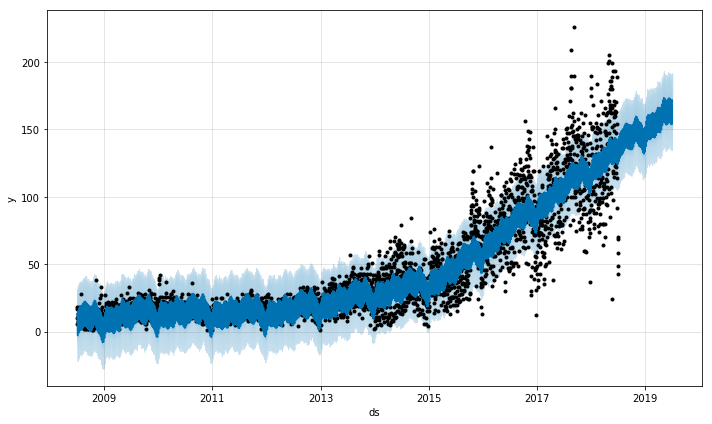

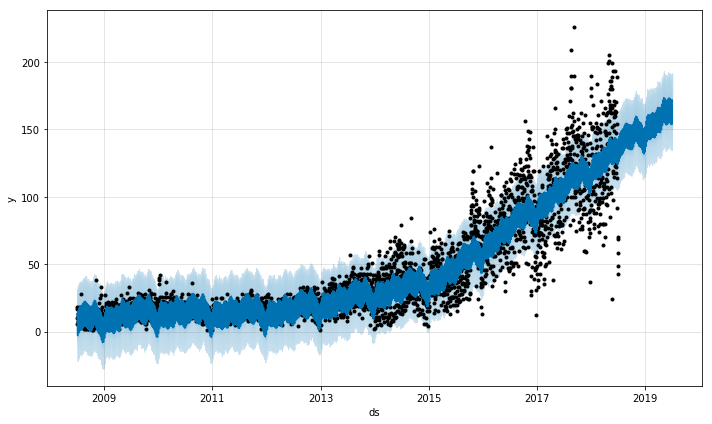

In [393]:
proph1.plot(fcst=forecast)

In [406]:
df_dummies = pd.get_dummies(df_regress[['Police District','Request Type','Responsible Agency','Request Details','Source']])

In [416]:
df_regress = df_regress[['datetime','CaseID','Supervisor District']]

In [499]:
df_regress = pd.concat([df_regress,df_dummies], axis=1)

In [501]:
df_regress.drop('DayWeek',axis=1,inplace=True)

In [522]:
df_reg = df_regress.groupby('datetime').agg({'CaseID':'count', 'Police District_BAYVIEW': 'sum', 'Police District_CENTRAL': 'sum','Police District_INGLESIDE': 'sum','Police District_MISSION': 'sum','Police District_NORTHERN': 'sum','Police District_PARK': 'sum','Police District_RICHMOND': 'sum','Police District_SOUTHERN': 'sum','Police District_TARAVAL': 'sum','Police District_TENDERLOIN': 'sum','Request Type_Human Waste': 'sum','Request Type_Individual Concerns': 'sum','Request Type_Medical Waste': 'sum','Request Details_Human Waste': 'sum','Request Details_Needles': 'sum','Request Details_aggressive_behavior': 'sum','Request Details_homeless_other': 'sum','Request Details_wellbeing_check': 'sum','Source_Integrated Agency': 'sum','Source_Mobile/Open311': 'sum','Source_Other Department': 'sum','Source_Phone': 'sum','Source_Twitter': 'sum','Source_Web': 'sum','DaysSince0': 'mean'})

In [496]:
df_dummies = pd.get_dummies(df_regress['DayWeek'])

In [497]:
df_dummies

Friday  Monday  Saturday  Sunday  Thursday  Tuesday  Wednesday
0            0       0         0       0         0        1          0
1            0       0         0       0         0        1          0
2            0       0         0       0         0        1          0
3            0       1         0       0         0        0          0
4            0       1         0       0         0        0          0
5            0       1         0       0         0        0          0
6            0       1         0       0         0        0          0
7            0       1         0       0         0        0          0
8            0       1         0       0         0        0          0
9            0       1         0       0         0        0          0
10           0       1         0       0         0        0          0
11           0       1         0       0         0        0          0
12           0       1         0       0         0        0          0
13           0       0         0       1         0        0          0
14           0       0         0       1         0        0          0
15           0       0         0       1         0        0          0
16           0       0         0       1         0        0          0
17           0       0         0       1         0        0          0
18           0       0         0       1         0        0          0
19           0       0         0       1         0        0          0
20           0       0         0       1         0        0          0
21           0       0         0       1         0        0          0
22           0       0         0       1         0        0          0
23           0       0         1       0         0        0          0
24           0       0         1       0         0        0          0
25           0       0         1       0         0        0          0
26           0       0         1       0         0        0          0
27           0       0         1       0         0        0          0
28           0       0         1       0         0        0          0
29           0       0         1       0         0        0          0
...        ...     ...       ...     ...       ...      ...        ...
158379       0       0         0       1         0        0          0
158380       0       0         0       1         0        0          0
158381       0       0         0       1         0        0          0
158382       0       0         0       1         0        0          0
158383       0       0         0       1         0        0          0
158384       0       0         0       0         0        0          1
158385       0       0         0       1         0        0          0
158386       0       0         0       1         0        0          0
158387       0       0         0       1         0        0          0
158388       0       0         0       1         0        0          0
158389       0       0         0       1         0        0          0
158390       0       0         0       1         0        0          0
158391       0       0         0       1         0        0          0
158392       0       0         0       1         0        0          0
158393       0       0         1       0         0        0          0
158394       0       0         1       0         0        0          0
158395       0       0         0       1         0        0          0
158396       1       0         0       0         0        0          0
158397       0       0         1       0         0        0          0
158398       0       0         0       0         0        1          0
158399       0       0         0       0         1        0          0
158400       0       0         0       1         0        0          0
158401       0       1         0       0         0        0          0
158402       0       0         0       0         0        1          0
158403       1       0         0

In [480]:
df_regress['DaysSince0'] = (df_regress['datetime'] - df_regress['datetime'].min()).dt.days

In [489]:
df_regress

datetime   CaseID  Police District_BAYVIEW  Police District_CENTRAL  \
0       2008-12-30   341397                        0                        0   
1       2008-12-30   341240                        0                        0   
2       2008-12-30   341209                        0                        1   
3       2008-12-29   341018                        0                        0   
4       2008-12-29   340877                        0                        0   
5       2008-12-29   340823                        0                        0   
6       2008-12-29   340800                        0                        1   
7       2008-12-29   340790                        0                        0   
8       2008-12-29   340768                        0                        0   
9       2008-12-29   340733                        0                        0   
10      2008-12-29   340412                        0                        0   
11      2008-12-29   340393                        0                        0   
12      2008-12-29   340272                        0                        0   
13      2008-12-28   340064                        0                        0   
14      2008-12-28   340012                        0                        0   
15      2008-12-28   340009                        0                        0   
16      2008-12-28   340005                        0                        0   
17      2008-12-28   339997                        0                        0   
18      2008-12-28   339904                        0                        1   
19      2008-12-28   339872                        0                        0   
20      2008-12-28   339871                        0                        0   
21      2008-12-28   339870                        0                        0   
22      2008-12-28   339843                        0                        0   
23      2008-12-27   339705                        0                        0   
24      2008-12-27   339688                        0                        0   
25      2008-12-27   339671                        0                        0   
26      2008-12-27   339654                        0                        0   
27      2008-12-27   339542                        0                        0   
28      2008-12-27   339539                        0                        0   
29      2008-12-27   339521                        0                        0   
...            ...      ...                      ...                      ...   
158379  2018-06-24  9179735                        0                        0   
158380  2018-06-24  9179806                        0                        0   
158381  2018-06-24  9179815                        0                        0   
158382  2018-06-24  9179877                        0                        0   
158383  2018-06-24  9179943                        0                        0   
158384  2017-11-01  8215193                        0                        0   
158385  2018-06-24  9180035                        0                        0   
158386  2018-06-24  9180044                        0                        0   
158387  2018-06-24  9180164                        1                        0   
158388  2018-06-24  9180255                        0                        1   
158389  2018-06-24  9180261                        0                        1   
158390  2018-06-24  9180304                        0                        0   
158391  2018-06-24  9180450                        0                        0   
158392  2018-06-24  9180550                        0                        0   
158393  2017-11-04  8226488                        0                        0   
158394  2017-11-04  8227728                        0                        0   
158395  2017-11-05  8229863                        0                        0   
158396  2017-11-10  8253403              

In [599]:
def diagnostic_plot(x, y):
    plt.figure(figsize=(20,5))
    
    rgr = LinearRegression()
    rgr.fit(x.reshape(s,1),y)
    pred = rgr.predict(x.reshape(s,1))

    plt.subplot(1, 3, 1)
    plt.scatter(x,y)
    plt.plot(x, pred, color='blue',linewidth=1)
    plt.title("Regression fit")
    plt.xlabel("x")
    plt.ylabel("y")
    
    plt.subplot(1, 3, 2)
    res = y - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")

In [629]:
lr.score(X,y)

0.636643798791501

In [622]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
from sklearn.cross_validation import train_test_split

In [619]:
model = sm.OLS(y,X)

In [620]:
fit = model.fit()

In [621]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 CaseID   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     9008.
Date:                Mon, 10 Sep 2018   Prob (F-statistic):               0.00
Time:                        17:18:04   Log-Likelihood:                -16961.
No. Observations:                3681   AIC:                         3.393e+04
Df Residuals:                    3679   BIC:                         3.394e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
DaysSince0     0.0291      0.000    107.367      0.000       0.029       0.030
DayWeek       -3.4845      0.160    -21.739      0.000      -3.799      -3.170
==============================================================================
Omnibus:                      318.961   Durbin-Watson:                   0.443
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1241.824
Skew:                           0.362   Prob(JB):                    2.19e-270
Kurtosis:                       5.752   Cond. No.                         853.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [614]:
df_reg2 = df_reg[['CaseID','DaysSince0','DayWeek']]

In [615]:
df_reg2

CaseID  DaysSince0  DayWeek
0         18           0        1
1         17           1        2
2         10           2        3
3          6           3        4
4          8           4        5
5          7           5        6
6         11           6        0
7         11           7        1
8         13           8        2
9         17           9        3
10        17          10        4
11         7          11        5
12         7          12        6
13        17          13        0
14        18          14        1
15        13          15        2
16        14          16        3
17         6          17        4
18         4          18        5
19        15          19        6
20        11          20        0
21        12          21        1
22        16          22        2
23         9          23        3
24         9          24        4
25         7          25        5
26        10          26        6
27        12          27        0
28         8          28        1
29        28          29        2
...      ...         ...      ...
3651       1        3658        5
3652       2        3659        6
3653       1        3661        1
3654       4        3662        2
3655       6        3663        3
3656       2        3665        5
3657       6        3666        6
3658       1        3667        0
3659       1        3670        3
3660       1        3671        4
3661       5        3672        5
3662       2        3673        6
3663       2        3674        0
3664       3        3675        1
3665       1        3677        3
3666       2        3679        5
3667       4        3680        6
3668       6        3681        0
3669       1        3682        1
3670       5        3683        2
3671       2        3684        3
3672       1        3685        4
3673       1        3687        6
3674       2        3688        0
3675       2        3689        1
3676       1        3693        5
3677       1        3697        2
3678       1        3699        4
3679       1        3700        5
3680       1        3707        5

[3681 rows x 3 columns]

In [767]:
X = df_reg3.iloc[:,1:]
y = df_reg3.iloc[:, 0]

In [1391]:
df_list

[             ds   y
 0    2008-07-01   1
 1    2008-07-02   1
 2    2008-07-04   1
 3    2008-07-06   1
 4    2008-07-14   1
 5    2008-07-17   1
 6    2008-07-24   1
 7    2008-07-30   2
 8    2008-07-31   1
 9    2008-08-04   2
 10   2008-08-20   2
 11   2008-08-22   2
 12   2008-09-01   1
 13   2008-09-06   1
 14   2008-09-11   1
 15   2008-09-21   1
 16   2008-09-22   2
 17   2008-10-05   1
 18   2008-10-09   1
 19   2008-10-13   1
 20   2008-10-20   1
 21   2008-10-24   2
 22   2008-10-25   1
 23   2008-10-27   1
 24   2008-10-28   2
 25   2008-10-29   1
 26   2008-11-08   2
 27   2008-11-14   1
 28   2008-11-23   1
 29   2008-11-27   1
 ...         ...  ..
 1837 2018-06-06   7
 1838 2018-06-07   5
 1839 2018-06-08   2
 1840 2018-06-09   5
 1841 2018-06-10   5
 1842 2018-06-11  13
 1843 2018-06-12   7
 1844 2018-06-13   7
 1845 2018-06-14   5
 1846 2018-06-15   4
 1847 2018-06-16   3
 1848 2018-06-17   5
 1849 2018-06-18   6
 1850 2018-06-19   9
 1851 2018-06-20   5
 1852 2018-06

In [44]:
def RMSE(actuals, preds): #root mean squared error
    return np.sqrt(np.mean((actuals - preds)**2))

def MAE(actuals, preds):
    return np.mean(abs(actuals - preds))

In [768]:
X_scaled = scaler.fit_transform(X)
X 

DayWeek  DaysSince0^2
0           1             0
1           2             1
2           3             4
3           4             9
4           5            16
5           6            25
6           0            36
7           1            49
8           2            64
9           3            81
10          4           100
11          5           121
12          6           144
13          0           169
14          1           196
15          2           225
16          3           256
17          4           289
18          5           324
19          6           361
20          0           400
21          1           441
22          2           484
23          3           529
24          4           576
25          5           625
26          6           676
27          0           729
28          1           784
29          2           841
...       ...           ...
3651        5      13380964
3652        6      13388281
3653        1      13402921
3654        2      13410244
3655        3      13417569
3656        5      13432225
3657        6      13439556
3658        0      13446889
3659        3      13468900
3660        4      13476241
3661        5      13483584
3662        6      13490929
3663        0      13498276
3664        1      13505625
3665        3      13520329
3666        5      13535041
3667        6      13542400
3668        0      13549761
3669        1      13557124
3670        2      13564489
3671        3      13571856
3672        4      13579225
3673        6      13593969
3674        0      13601344
3675        1      13608721
3676        5      13638249
3677        2      13667809
3678        4      13682601
3679        5      13690000
3680        5      13741849

[3681 rows x 2 columns]

In [632]:
lr.predict(X)

array([ -4.88163924,  -8.14649768, -11.41135613, ...,  94.55513765,
        91.29027921,  91.49715677])

In [633]:
from sklearn.cross_validation import train_test_split

In [769]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3)

In [770]:
X_train

array([[-0.99966048, -0.53355422],
       [ 0.50023771,  1.87405359],
       [ 1.00020377, -0.00426914],
       ...,
       [ 1.50016984,  0.37733972],
       [-0.49969442, -0.30040464],
       [-0.49969442,  1.39783217]])

In [637]:
scaler = StandardScaler()

In [771]:
lr1 = lr.fit(X_train,y_train)

In [772]:
lr1.score(X_test,y_test)

0.7585310415176114

In [731]:
np.mean(y_test-lr1.predict(X_test))**2

0.004260627412973896

In [669]:
y_pred = lr1.predict(X_test)

In [676]:
mse

1.5297952786446019

In [670]:
y_pred

array([27.06539351,  7.27863782, 22.93235674, ..., 11.05544715,
        1.19377833, -8.16525837])

In [664]:
from sklearn.cross_validation import cross_val_score

In [679]:
scores = cross_val_score(lr1, X_train, y_train, cv=4, scoring='mean_absolute_error')

In [680]:
scores

array([-18.39694106, -18.31414457, -18.52820041, -19.59997396])

In [685]:
import diagnostic_plots

In [687]:
from sklearn.preprocessing import PolynomialFeatures

In [690]:
df_year = df_group_total.reset_index()

In [693]:
df_year['year'] = df_year['datetime'].dt.year

In [697]:
df_year = df_year.groupby('year').agg({'CaseID': 'sum'})

In [702]:
df_year = df_year.iloc[0:10]

(array([-5000.,     0.,  5000., 10000., 15000., 20000., 25000., 30000.,
        35000., 40000., 45000.]), <a list of 11 Text yticklabel objects>)

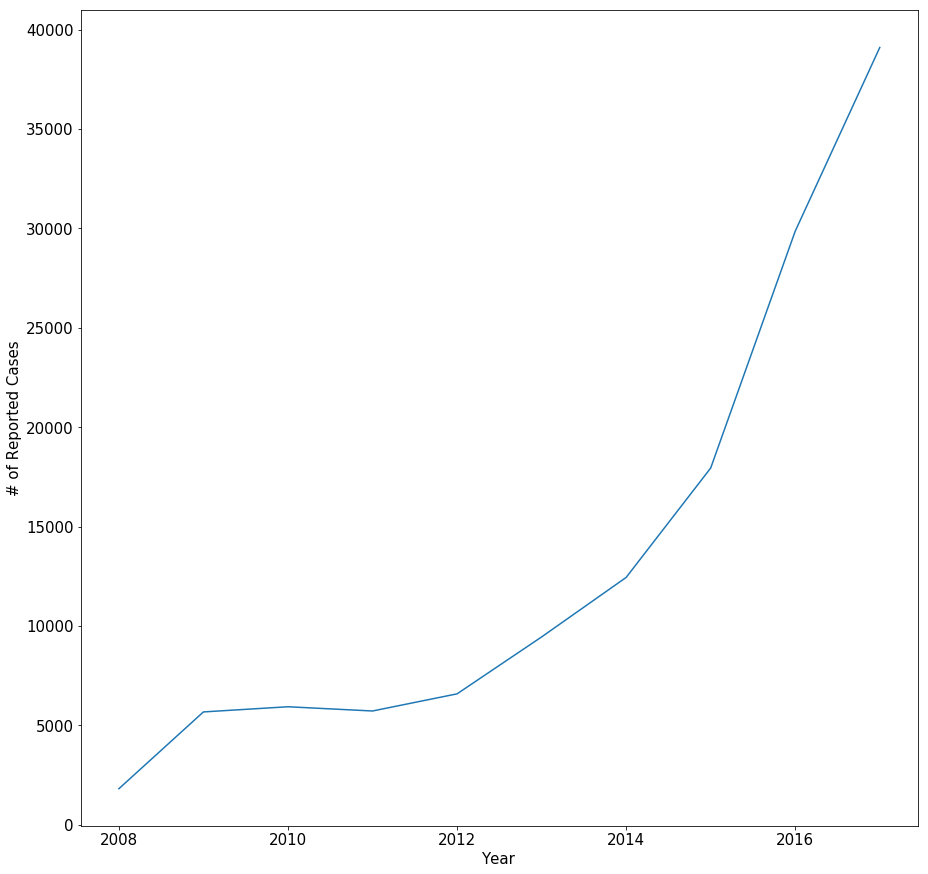

In [721]:
plt.figure(figsize=(15,15))
plt.plot(df_year)
plt.ylabel('# of Reported Cases', fontsize=15)
plt.xlabel('Year', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

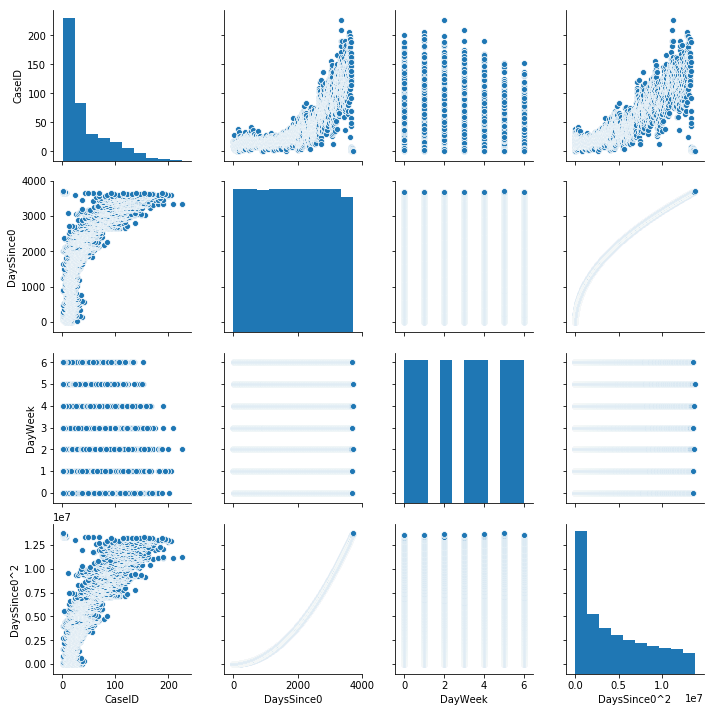

In [737]:
sns.pairplot(df_reg2)

In [735]:
df_reg2['DaysSince0^2'] = df_reg2['DaysSince0']**2

/Users/harmsway/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [1382]:
X_train


array([[-0.99966048, -0.53355422],
       [ 0.50023771,  1.87405359],
       [ 1.00020377, -0.00426914],
       ...,
       [ 1.50016984,  0.37733972],
       [-0.49969442, -0.30040464],
       [-0.49969442,  1.39783217]])

In [747]:
train_error = np.empty(10)
test_error = np.empty(10)
for degree in range(10):
    est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    est.fit(X_train, y_train)
    train_error[degree] = mean_absolute_error(y_train, est.predict(X_train))
    test_error[degree] = mean_absolute_error(y_test, est.predict(X_test))

In [749]:
train_error

array([31.52468136, 18.00971523, 11.11154069, 10.62924459, 10.43179757,
       10.3942885 ,  9.95388698,  9.75923293,  9.78542137,  9.65120626])

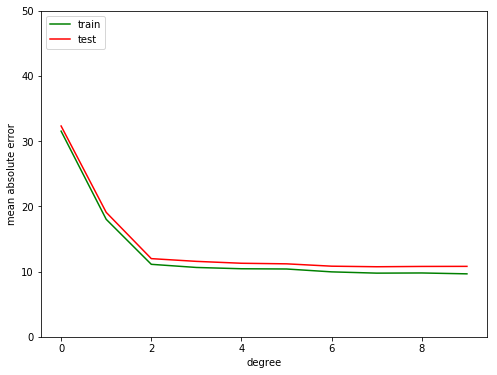

In [754]:
plt.figure(figsize=(8,6))
plt.plot(np.arange(10), train_error, color='green', label='train')
plt.plot(np.arange(10), test_error, color='red', label='test')
plt.ylim((0.0, 50))
plt.ylabel('mean absolute error')
plt.xlabel('degree')
plt.legend(loc='upper left')

In [408]:
scaler = StandardScaler()
models = [('Lasso', Lasso),
          ('Ridge', Ridge),
          ('Linear', LinearRegression), 
          ('Random Forest', RandomForestRegressor),
          ('tree', DecisionTreeRegressor),
         ('gradient', GradientBoostingRegressor)]

params_choices = [
    {
    'alpha': [500, 800, 1000, 1300, 2000, 5000],
    'max_iter': [1000, 2000, 4000]
    },
    {
    'alpha': [500, 800, 1000, 1300, 2000, 5000],
    'max_iter': [1000, 2000, 4000],
    },
    {
        
    },
    {
        'max_depth': [2, 5, 10, 100, 500],
        'criterion': ['mae']
    },
    {
        'max_depth': [2, 5, 6,7,8, 10, 15, 25, 30, 35],
        'criterion': ['mae']
    },
    {
        'n_estimators': [2, 5, 10 , 20],
        'max_depth': [2, 5, 6,7,8, 10, 15, 25, 30, 35]
    }]

grids = {}
for area in df_homeless_agg.columns:
    df = pd.DataFrame(df_homeless_agg[area])
    df.reset_index(inplace=True)
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['DaysSince0'] = ((df['datetime'] - min(df['datetime'])).dt.days)**2
    df['dayweek'] = df['datetime'].dt.dayofweek
    df['month'] = df['datetime'].dt.month
    df['lag_6'] = df[area].shift(6)
    df['ma_7'] = df[area].rolling(7).mean()
    df.fillna(0, inplace=True)
    df.drop('datetime',inplace=True, axis=1)
    X = df.iloc[:,1:]
    y = df.iloc[:,0]
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3)
    for model_info, params in zip(models, params_choices):
        name, model = model_info
        grid = GridSearchCV(model(), params, scoring='r2', cv=8)
        grid.fit(X_train, y_train)
        s = f"{name} {area}: best score: {grid.best_score_}, test score {grid.score(X_test,y_test)}"
        print(s)
        grids[name] = grid

Lasso CENTRAL: best score: -0.0040602338824545035, test score -2.9915416760450952e-05
Ridge CENTRAL: best score: 0.7591590060365011, test score 0.7512627928996206
Linear CENTRAL: best score: 0.7931958903751232, test score 0.7954052649444207
Random Forest CENTRAL: best score: 0.7811110609841263, test score 0.7828070709829308
tree CENTRAL: best score: 0.7588794350668525, test score 0.7697025252300949
gradient CENTRAL: best score: 0.7710089615894373, test score 0.7722575518348593
Lasso MISSION: best score: -0.004488542159239973, test score -0.0024490386032143263
Ridge MISSION: best score: 0.8245433006853456, test score 0.8193528204637
Linear MISSION: best score: 0.8629802226707216, test score 0.8477887232201647
Random Forest MISSION: best score: 0.8541852966303869, test score 0.841239430497544
tree MISSION: best score: 0.8385073628928957, test score 0.8325989058972545
gradient MISSION: best score: 0.8450538756652451, test score 0.8289593036879153
Lasso NORTHERN: best score: -0.00290382141

In [407]:
scaler = StandardScaler()
models = [('Lasso', Lasso),
          ('Ridge', Ridge),
          ('Linear', LinearRegression), 
          ('Random Forest', RandomForestRegressor),
          ('tree', DecisionTreeRegressor),
         ('gradient', GradientBoostingRegressor)]

params_choices = [
    {
    'alpha': [500, 800, 1000, 1300, 2000, 5000],
    'max_iter': [1000, 2000, 4000]
    },
    {
    'alpha': [500, 800, 1000, 1300, 2000, 5000],
    'max_iter': [1000, 2000, 4000],
    },
    {
        
    },
    {
        'max_depth': [2, 5, 10, 100, 500],
        'criterion': ['mae']
    },
    {
        'max_depth': [2, 5, 6,7,8, 10, 15, 25, 30, 35],
        'criterion': ['mae']
    },
    {
        'n_estimators': [2, 5, 10 , 20],
        'max_depth': [2, 5, 6,7,8, 10, 15, 25, 30, 35]
    }]

grids = {}
for area in df_homeless_agg.columns:
    df = pd.DataFrame(df_homeless_agg[area])
    df.reset_index(inplace=True)
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['DaysSince0'] = ((df['datetime'] - min(df['datetime'])).dt.days)**2
    df['dayweek'] = df['datetime'].dt.dayofweek
    df['month'] = df['datetime'].dt.month
    df['lag_6'] = df[area].shift(6)
    df['ma_7'] = df[area].rolling(7).mean()
    df.fillna(0, inplace=True)
    df.drop('datetime',inplace=True, axis=1)
    X = df.iloc[:,1:]
    y = df.iloc[:,0]
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3)
    for model_info, params in zip(models, params_choices):
        name, model = model_info
        grid = GridSearchCV(model(), params, scoring='neg_mean_absolute_error', cv=8)
        grid.fit(X_train, y_train)
        s = f"{name} {area}: best score: {grid.best_score_}, test score {grid.score(X_test,y_test)}"
        print(s)
        grids[name] = grid

Lasso CENTRAL: best score: -3.7345207365220943, test score -3.8858930212434246
Ridge CENTRAL: best score: -1.5980253797165789, test score -1.645073875088527
Linear CENTRAL: best score: -1.4677408363687041, test score -1.5056540859073175
Random Forest CENTRAL: best score: -1.4872161315583399, test score -1.4795890410958905
tree CENTRAL: best score: -1.5268206734534064, test score -1.5424657534246575
gradient CENTRAL: best score: -1.5659565927846066, test score -1.6545679815408703
Lasso MISSION: best score: -9.42574850065085, test score -9.179041560735598
Ridge MISSION: best score: -3.3014610365058576, test score -3.2019275337270194
Linear MISSION: best score: -2.95555801742069, test score -2.8618088726905206
Random Forest MISSION: best score: -2.933437744714174, test score -2.846940639269406
tree MISSION: best score: -3.0794831636648397, test score -2.9269406392694064
gradient MISSION: best score: -3.126861306269244, test score -3.0337071308165235
Lasso NORTHERN: best score: -3.69774636

In [406]:
df_homeless_agg.CENTRAL.reset_index()

datetime  CENTRAL
0     2008-07-01      0.0
1     2008-07-02      1.0
2     2008-07-03      0.0
3     2008-07-04      0.0
4     2008-07-05      0.0
5     2008-07-06      0.0
6     2008-07-07      2.0
7     2008-07-08      0.0
8     2008-07-09      1.0
9     2008-07-10      1.0
10    2008-07-11      2.0
11    2008-07-12      1.0
12    2008-07-13      2.0
13    2008-07-14      1.0
14    2008-07-15      0.0
15    2008-07-16      0.0
16    2008-07-17      0.0
17    2008-07-18      0.0
18    2008-07-19      0.0
19    2008-07-20      1.0
20    2008-07-21      3.0
21    2008-07-22      1.0
22    2008-07-23      1.0
23    2008-07-24      0.0
24    2008-07-25      0.0
25    2008-07-26      1.0
26    2008-07-27      0.0
27    2008-07-28      1.0
28    2008-07-29      0.0
29    2008-07-30      1.0
...          ...      ...
3619  2018-06-03     21.0
3620  2018-06-04     26.0
3621  2018-06-05     16.0
3622  2018-06-06     18.0
3623  2018-06-07     21.0
3624  2018-06-08     16.0
3625  2018-06-09     10.0
3626  2018-06-10     13.0
3627  2018-06-11     21.0
3628  2018-06-12     23.0
3629  2018-06-13     21.0
3630  2018-06-14     22.0
3631  2018-06-15     15.0
3632  2018-06-16     17.0
3633  2018-06-17     20.0
3634  2018-06-18     15.0
3635  2018-06-19     23.0
3636  2018-06-20     21.0
3637  2018-06-21     15.0
3638  2018-06-22     22.0
3639  2018-06-23     15.0
3640  2018-06-24     10.0
3641  2018-06-25     22.0
3642  2018-06-26     18.0
3643  2018-06-27     23.0
3644  2018-06-28     15.0
3645  2018-06-29     11.0
3646  2018-06-30      3.0
3647  2018-07-01      5.0
3648  2018-07-02      1.0

[3649 rows x 2 columns]

In [341]:
scaler = StandardScaler()
models = [('Lasso', Lasso),
          ('Ridge', Ridge),
          ('Linear', LinearRegression), 
          ('Random Forest', RandomForestRegressor),
          ('tree', DecisionTreeRegressor),
         ('gradient', GradientBoostingRegressor)]

params_choices = [
    {
    'alpha': [500, 800, 1000, 1300, 2000, 5000],
    'max_iter': [1000, 2000, 4000]
    },
    {
    'alpha': [500, 800, 1000, 1300, 2000, 5000],
    'max_iter': [1000, 2000, 4000],
    },
    {
        
    },
    {
        'max_depth': [2, 5, 10, 100, 500],
        'criterion': ['mae']
    },
    {
        'max_depth': [2, 5, 6,7,8, 10, 15, 25, 30, 35],
        'criterion': ['mae']
    },
    {
        'n_estimators': [2, 5, 10 , 20],
        'max_depth': [2, 5, 6,7,8, 10, 15, 25, 30, 35]
    }]

grids = {}
for area in df_pivot.CaseID.columns:
    df = pd.DataFrame(df_pivot.CaseID[area])
    df.reset_index(inplace=True)`
    df['DaysSince0'] = ((df['datetime'] - min(df['datetime'])).dt.days)**2
    df['dayweek'] = df['datetime'].dt.dayofweek
    df['month'] = df['datetime'].dt.month
    df['lag_6'] = df[area].shift(6)
    df['ma_7'] = df[area].rolling(7).mean()
    df.fillna(0, inplace=True)
    df.drop('datetime',inplace=True, axis=1)
    X = df.iloc[:,1:]
    y = df.iloc[:,0]
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3)
    for model_info, params in zip(models, params_choices):
        name, model = model_info
        grid = GridSearchCV(model(), params, scoring='r2', cv=8)
        grid.fit(X_train, y_train)
        s = f"{name} {area}: best score: {grid.best_score_}, test score {grid.score(X_test,y_test)}"
        print(s)
        grids[name] = grid

Lasso BAYVIEW: best score: -0.0018151528528562032, test score -0.0007137529415082167
Ridge BAYVIEW: best score: 0.47189396594770816, test score 0.5173432790472299
Linear BAYVIEW: best score: 0.2916875275748767, test score 0.16187393421245122
Random Forest BAYVIEW: best score: 0.40142047224286315, test score 0.4430118913482166
tree BAYVIEW: best score: 0.4092234733767731, test score 0.46651897968667444
gradient BAYVIEW: best score: 0.3190652065740633, test score 0.2182024201549546
Lasso CENTRAL: best score: -0.0010660503610494937, test score -0.00020076941712043883
Ridge CENTRAL: best score: 0.7514418552497673, test score 0.7690695846860786
Linear CENTRAL: best score: 0.7903480509365953, test score 0.8055968553079152
Random Forest CENTRAL: best score: 0.7672904187434104, test score 0.7996484989657701
tree CENTRAL: best score: 0.7473775106016548, test score 0.7751652900279686
gradient CENTRAL: best score: 0.7605210576644986, test score 0.7833081625001294
Lasso INGLESIDE: best score: -0.0

In [401]:
df_homeless_agg

Police District  CENTRAL  MISSION  NORTHERN  SOUTHERN  TENDERLOIN  \
datetime                                                            
2008-07-01           0.0      2.0       6.0       4.0         4.0   
2008-07-02           1.0      2.0       4.0       4.0         3.0   
2008-07-03           0.0      3.0       1.0       2.0         3.0   
2008-07-04           0.0      1.0       2.0       0.0         2.0   
2008-07-05           0.0      1.0       1.0       1.0         4.0   
2008-07-06           0.0      3.0       0.0       1.0         1.0   
2008-07-07           2.0      2.0       3.0       1.0         2.0   
2008-07-08           0.0      4.0       1.0       1.0         3.0   
2008-07-09           1.0      3.0       1.0       5.0         2.0   
2008-07-10           1.0      2.0       1.0       8.0         1.0   
2008-07-11           2.0      7.0       1.0       2.0         4.0   
2008-07-12           1.0      1.0       1.0       3.0         0.0   
2008-07-13           2.0      1.0       1.0       1.0         2.0   
2008-07-14           1.0      5.0       0.0       6.0         3.0   
2008-07-15           0.0      6.0       3.0       3.0         3.0   
2008-07-16           0.0      3.0       1.0       6.0         1.0   
2008-07-17           0.0      2.0       2.0       7.0         1.0   
2008-07-18           0.0      1.0       0.0       0.0         2.0   
2008-07-19           0.0      1.0       0.0       1.0         0.0   
2008-07-20           1.0      1.0       1.0       0.0        10.0   
2008-07-21           3.0      3.0       1.0       1.0         2.0   
2008-07-22           1.0      1.0       5.0       2.0         3.0   
2008-07-23           1.0      4.0       0.0       5.0         6.0   
2008-07-24           0.0      2.0       1.0       1.0         3.0   
2008-07-25           0.0      2.0       0.0       5.0         2.0   
2008-07-26           1.0      3.0       0.0       1.0         2.0   
2008-07-27           0.0      3.0       0.0       3.0         4.0   
2008-07-28           1.0      4.0       2.0       2.0         1.0   
2008-07-29           0.0      2.0       0.0       6.0         0.0   
2008-07-30           1.0      3.0       3.0      10.0         6.0   
...                  ...      ...       ...       ...         ...   
2018-06-03          21.0     39.0      12.0      38.0         8.0   
2018-06-04          26.0     38.0      20.0      45.0        14.0   
2018-06-05          16.0     50.0      26.0      35.0        19.0   
2018-06-06          18.0     31.0      15.0      46.0        19.0   
2018-06-07          21.0     37.0      17.0      36.0        18.0   
2018-06-08          16.0     34.0      16.0      32.0        15.0   
2018-06-09          10.0     38.0      19.0      24.0        13.0   
2018-06-10          13.0     37.0      18.0      27.0        10.0   
2018-06-11          21.0     39.0      17.0      29.0        29.0   
2018-06-12          23.0     37.0      22.0      50.0        39.0   
2018-06-13          21.0     44.0      18.0      28.0        24.0   
2018-06-14          22.0     39.0      15.0      40.0        24.0   
2018-06-15          15.0     37.0      11.0      29.0        25.0   
2018-06-16          17.0     19.0      19.0      30.0         8.0   
2018-06-17          20.0     44.0      18.0      19.0        10.0   
2018-06-18          15.0     34.0      19.0      37.0        34.0   
2018-06-19          23.0     27.0      23.0      28.0        39.0   
2018-06-20          21.0     25.0      19.0      24.0        19.0   
2018-06-21          15.0     29.0      15.0      29.0        17.0   
2018-06-22          22.0     23.0      15.0      36.0        18.0   
2018-06-23          15.0     31.0      18.0      26.0        13.0   
2018-06-24          10.0     25.0      16.0      18.0         9.0   
2018-06-25          22.0     36.0      26.0      44.0        29.0   
2018-06-26          18.0     21.0      22.0      35.0        21.0   
2018-06-27          23.0     25.0      12.0      31.0        19.0  

In [340]:
df.fillna(0)

BAYVIEW  DaysSince0  dayweek  month  lag_6      ma_7
0         1.0           0        1      7    NaN       NaN
1         1.0           1        2      7    NaN       NaN
2         0.0           4        3      7    NaN       NaN
3         1.0           9        4      7    NaN       NaN
4         0.0          16        5      7    NaN       NaN
5         1.0          25        6      7    NaN       NaN
6         0.0          36        0      7    1.0  0.571429
7         0.0          49        1      7    1.0  0.428571
8         0.0          64        2      7    0.0  0.285714
9         0.0          81        3      7    1.0  0.285714
10        0.0         100        4      7    0.0  0.142857
11        0.0         121        5      7    1.0  0.142857
12        0.0         144        6      7    0.0  0.000000
13        1.0         169        0      7    0.0  0.142857
14        0.0         196        1      7    0.0  0.142857
15        0.0         225        2      7    0.0  0.142857
16        1.0         256        3      7    0.0  0.285714
17        0.0         289        4      7    0.0  0.285714
18        0.0         324        5      7    0.0  0.285714
19        0.0         361        6      7    1.0  0.285714
20        0.0         400        0      7    0.0  0.142857
21        0.0         441        1      7    0.0  0.142857
22        0.0         484        2      7    1.0  0.142857
23        1.0         529        3      7    0.0  0.142857
24        0.0         576        4      7    0.0  0.142857
25        0.0         625        5      7    0.0  0.142857
26        0.0         676        6      7    0.0  0.142857
27        0.0         729        0      7    0.0  0.142857
28        0.0         784        1      7    0.0  0.142857
29        2.0         841        2      7    1.0  0.428571
...       ...         ...      ...    ...    ...       ...
3619      0.0    13133376        6      6    1.0  2.000000
3620      7.0    13140625        0      6    2.0  2.857143
3621      2.0    13147876        1      6    4.0  2.857143
3622      7.0    13155129        2      6    3.0  3.285714
3623      5.0    13162384        3      6    2.0  3.571429
3624      2.0    13169641        4      6    2.0  3.571429
3625      5.0    13176900        5      6    0.0  4.000000
3626      5.0    13184161        6      6    7.0  4.714286
3627     13.0    13191424        0      6    2.0  5.571429
3628      7.0    13198689        1      6    7.0  6.285714
3629      7.0    13205956        2      6    5.0  6.285714
3630      5.0    13213225        3      6    2.0  6.285714
3631      4.0    13220496        4      6    5.0  6.571429
3632      3.0    13227769        5      6    5.0  6.285714
3633      5.0    13235044        6      6   13.0  6.285714
3634      6.0    13242321        0      6    7.0  5.285714
3635      9.0    13249600        1      6    7.0  5.571429
3636      5.0    13256881        2      6    5.0  5.285714
3637      5.0    13264164        3      6    4.0  5.285714
3638      7.0    13271449        4      6    3.0  5.714286
3639      6.0    13278736        5      6    5.0  6.142857
3640      6.0    13286025        6      6    6.0  6.285714
3641      7.0    13293316        0      6    9.0  6.428571
3642      5.0    13300609        1      6    5.0  5.857143
3643     12.0    13307904        2      6    5.0  6.857143
3644      3.0    13315201        3      6    7.0  6.571429
3645      3.0    13322500        4      6    6.0  6.000000
3646      1.0    13329801        5      6    6.0  5.285714
3647      1.0    13337104        6      7    7.0  4.571429
3648      4.0    13344409        0      7    5.0  4.142857

[3649 rows x 6 columns]

In [333]:
scaler = StandardScaler()
models = [('Lasso', Lasso),
          ('Ridge', Ridge),
          ('Linear', LinearRegression), 
          ('Random Forest', RandomForestRegressor),
          ('tree', DecisionTreeRegressor),
         ('gradient', GradientBoostingRegressor)]

params_choices = [
    {
    'alpha': [500, 800, 1000, 1300, 2000, 5000],
    'max_iter': [1000, 2000, 4000]
    },
    {
    'alpha': [500, 800, 1000, 1300, 2000, 5000],
    'max_iter': [1000, 2000, 4000],
    },
    {
        
    },
    {
        'max_depth': [2, 5, 10, 100, 500],
        'criterion': ['mae']
    },
    {
        'max_depth': [2, 5, 6,7,8, 10, 15, 25, 30, 35],
        'criterion': ['mae']
    },
    {
        'n_estimators': [2, 5, 10 , 20],
        'max_depth': [2, 5, 6,7,8, 10, 15, 25, 30, 35]
    }]

grids = {}
for area in df_pivot.CaseID.columns:
    df = pd.DataFrame(df_pivot.CaseID[area])
    df.reset_index(inplace=True)
    df['DaysSince0'] = ((df['datetime'] - min(df['datetime'])).dt.days)**2
    df['dayweek'] = df['datetime'].dt.dayofweek
    df['month'] = df['datetime'].dt.month
    df['lag_6'] = df[area].shift(6)
    df['ma_7'] = df[area].rolling(7).mean()
    df.drop('datetime',inplace=True, axis=1)
    X = df.iloc[:,1:]
    y = df.iloc[:,0]
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3)
    for model_info, params in zip(models, params_choices):
        name, model = model_info
        grid = GridSearchCV(model(), params, scoring='r2', cv=8)
        grid.fit(X_train, y_train)
        s = f"{name} {area}: best score: {grid.best_score_}, test score {grid.score(X_test,y_test)}"
        print(s)
        grids[name] = grid

Lasso BAYVIEW: best score: -0.00788365810250455, test score -9.05302978480016e-05
Ridge BAYVIEW: best score: 0.32897914383975063, test score 0.28436278330596976
Linear BAYVIEW: best score: 0.33036547736328137, test score 0.2936474688637011
Random Forest BAYVIEW: best score: 0.388462127050077, test score 0.4495096752132687
tree BAYVIEW: best score: 0.4090504345540663, test score 0.349163682333829
gradient BAYVIEW: best score: 0.5136808289781634, test score 0.42687259135371813
Lasso CENTRAL: best score: -0.004540840221041818, test score -3.242515399404233e-05
Ridge CENTRAL: best score: 0.6250433587729418, test score 0.6436139347974563
Linear CENTRAL: best score: 0.6468783500271201, test score 0.6549140856779596
Random Forest CENTRAL: best score: 0.747751190041362, test score 0.7546932380302143
tree CENTRAL: best score: 0.7230240297657234, test score 0.7370788916124302
gradient CENTRAL: best score: 0.7427376571575072, test score 0.7592146917751709
Lasso INGLESIDE: best score: -0.001947680

In [321]:
df.drop('datetime',inplace=True, axis=1)

In [834]:
df_neigh = (df_homeless_call.reset_index()
            .groupby(['Police District', 'datetime'])
            .agg({'CaseID': 'count'}))

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/harmsway/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.fore

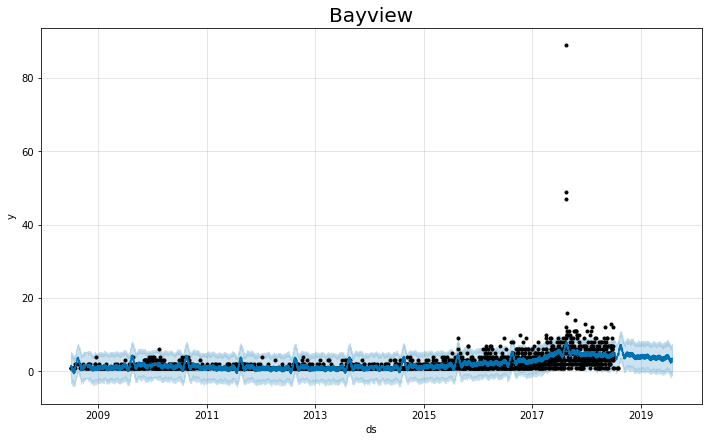

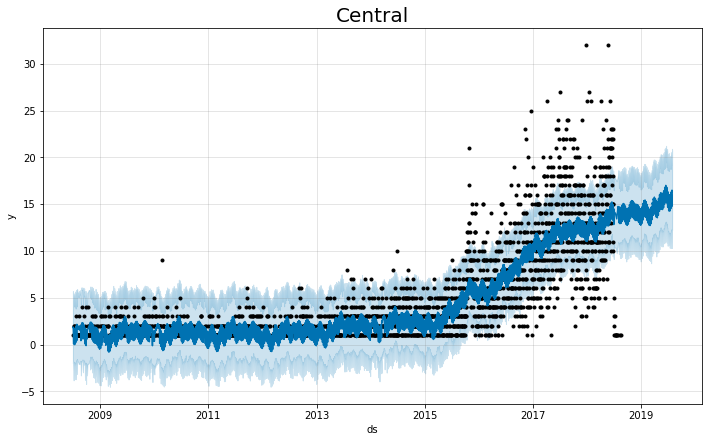

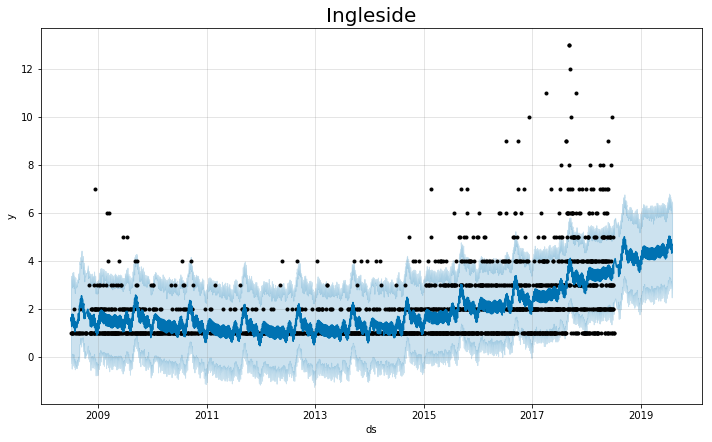

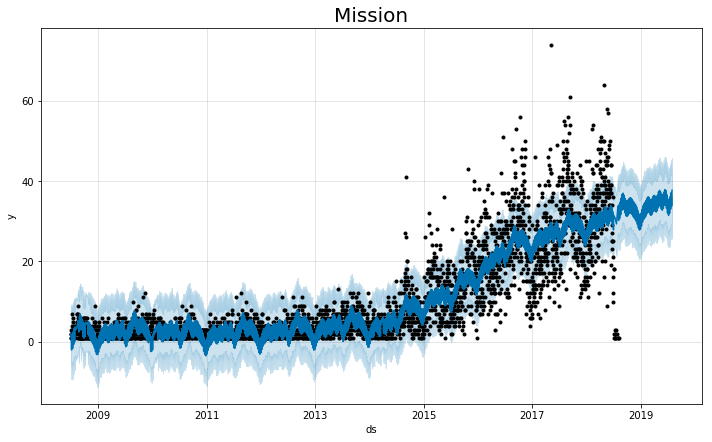

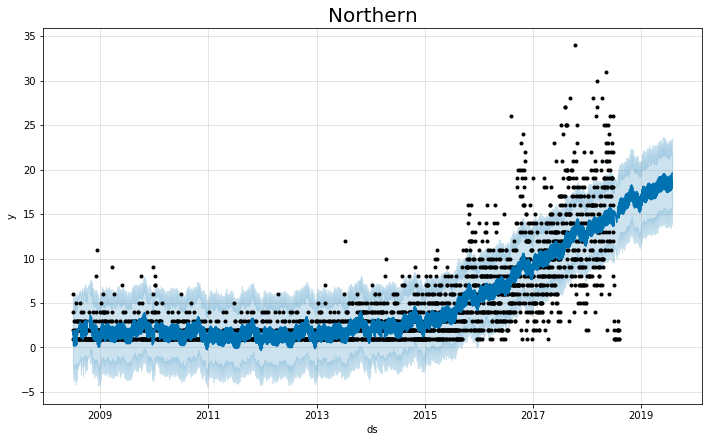

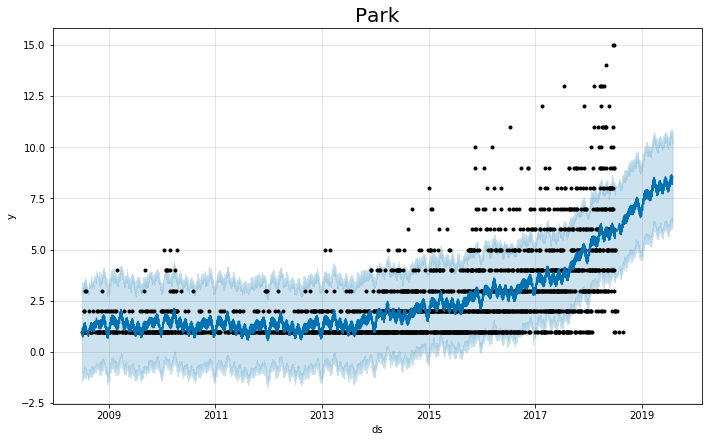

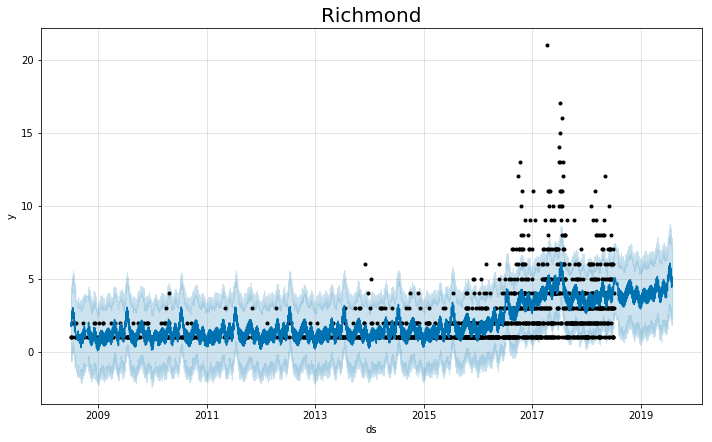

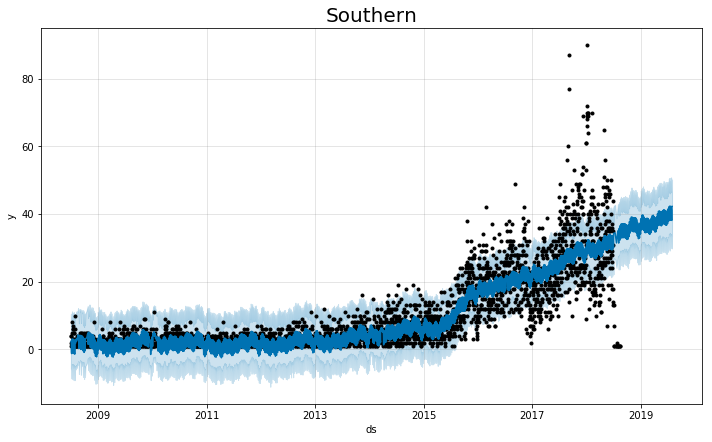

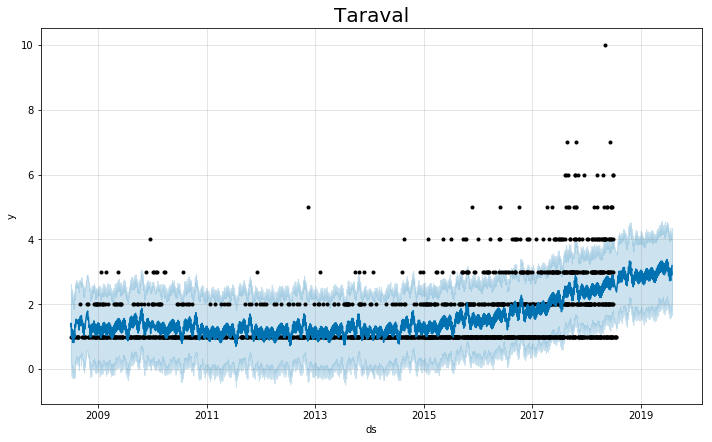

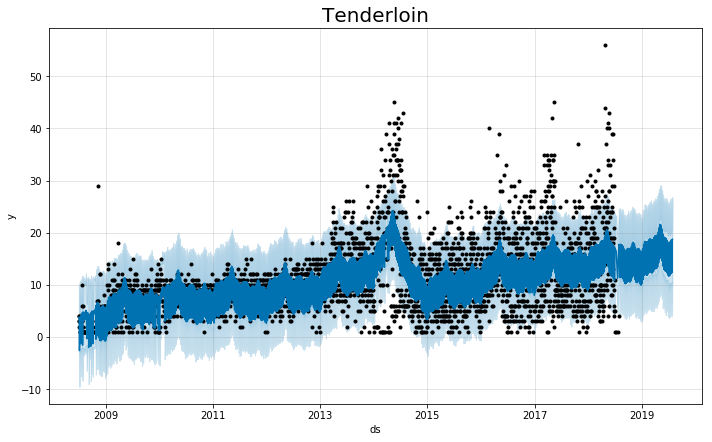

In [1000]:
#Create Graphs
counter = 0
for i in range(len(df_list)):
    m = Prophet(changepoint_prior_scale=0.5)
    counter += i
    dataframe = df_list[i]
    m.fit(dataframe)
    fcst = m.predict(future)
    fig = m.plot(fcst)
    plt.title(dataframe.name, fontsize=20)
    
    
    
    
    

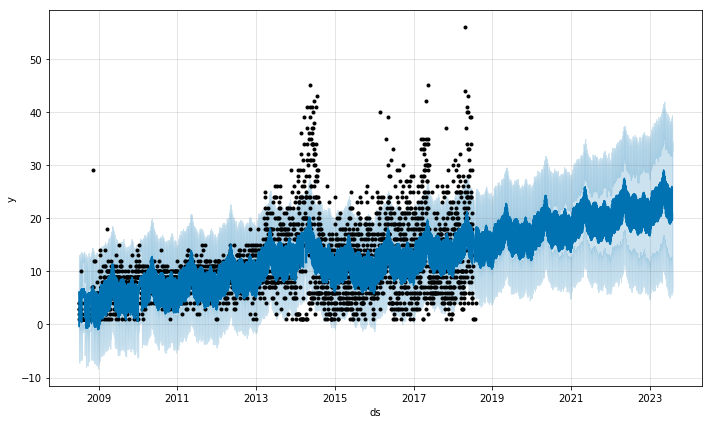

In [1017]:
dataframe
future = m.make_future_dataframe(periods=1826)
fcst = m.predict(future)
fig = m.plot(fcst)

In [982]:
future = m.make_future_dataframe(periods=730)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/harmsway/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Text(0.5,1,'Taraval')

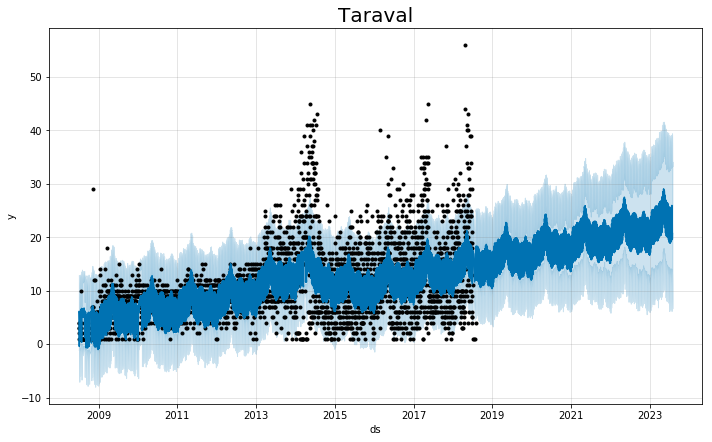

In [1049]:
Tenderloin = Prophet()
Tenderloin.fit(df_TENDERLOIN)
tender_fcst = Tenderloin.predict(future)
tender_fig = Tenderloin.plot(fcst)
plt.title(df_TARAVAL.name, fontsize=20)

In [ ]:
pred = Bayview.make_future_dataframe()

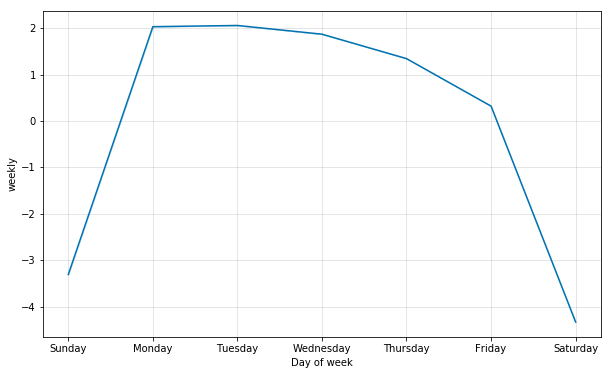

In [1036]:
#m.plot_components(fcst)
m.plot_weekly()

In [1196]:
df_cv = cross_validation(m, initial='1500 days', period='100 days', horizon = '500 days')

INFO:fbprophet.diagnostics:Making 18 forecasts with cutoffs between 2012-08-16 00:00:00 and 2017-04-12 00:00:00
/Users/harmsway/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [1197]:
df_cv

ds      yhat  yhat_lower  yhat_upper    y     cutoff
0    2012-08-17  0.702508   -0.254025    1.576274  0.0 2012-08-16
1    2012-08-18  0.611750   -0.263531    1.586558  0.0 2012-08-16
2    2012-08-19  0.600809   -0.319146    1.495810  1.0 2012-08-16
3    2012-08-20  0.899238   -0.048138    1.843429  1.0 2012-08-16
4    2012-08-21  0.512082   -0.464362    1.498565  0.0 2012-08-16
5    2012-08-22  0.528112   -0.462231    1.453739  0.0 2012-08-16
6    2012-08-23  0.624429   -0.336726    1.601717  0.0 2012-08-16
7    2012-08-24  0.635257   -0.240284    1.589382  0.0 2012-08-16
8    2012-08-25  0.536585   -0.456108    1.446499  1.0 2012-08-16
9    2012-08-26  0.519750   -0.395513    1.479844  0.0 2012-08-16
10   2012-08-27  0.814351   -0.132087    1.739152  0.0 2012-08-16
11   2012-08-28  0.425422   -0.477888    1.454465  1.0 2012-08-16
12   2012-08-29  0.441653   -0.517484    1.397052  1.0 2012-08-16
13   2012-08-30  0.540009   -0.390182    1.539557  0.0 2012-08-16
14   2012-08-31  0.554522   -0.391495    1.508111  0.0 2012-08-16
15   2012-09-01  0.460939   -0.474949    1.363802  0.0 2012-08-16
16   2012-09-02  0.450317   -0.479004    1.489680  0.0 2012-08-16
17   2012-09-03  0.751942   -0.199915    1.714369  0.0 2012-08-16
18   2012-09-04  0.370511   -0.631200    1.309513  2.0 2012-08-16
19   2012-09-05  0.394368   -0.572361    1.312927  0.0 2012-08-16
20   2012-09-06  0.500133   -0.378418    1.487612  2.0 2012-08-16
21   2012-09-07  0.521500   -0.416392    1.437511  1.0 2012-08-16
22   2012-09-08  0.433901   -0.433819    1.346738  0.0 2012-08-16
23   2012-09-09  0.428108   -0.457084    1.380086  0.0 2012-08-16
24   2012-09-10  0.733165   -0.292774    1.635570  0.0 2012-08-16
25   2012-09-11  0.353571   -0.544136    1.345001  0.0 2012-08-16
26   2012-09-12  0.377530   -0.556012    1.344203  0.0 2012-08-16
27   2012-09-13  0.481577   -0.467432    1.449082  1.0 2012-08-16
28   2012-09-14  0.499387   -0.358264    1.449947  1.0 2012-08-16
29   2012-09-15  0.406435   -0.556393    1.373760  0.0 2012-08-16
...         ...       ...         ...         ...  ...        ...
8948 2018-07-07  4.187335    2.900996    5.576852  0.0 2017-04-12
8949 2018-07-08  4.150678    2.796895    5.525528  0.0 2017-04-12
8950 2018-07-10  4.485546    3.128075    5.906457  0.0 2017-04-12
8951 2018-07-11  4.470349    3.043385    5.734747  0.0 2017-04-12
8952 2018-07-12  4.522479    3.209672    5.900875  0.0 2017-04-12
8953 2018-07-14  4.179174    2.741636    5.644279  0.0 2017-04-12
8954 2018-07-15  4.143132    2.790000    5.468636  0.0 2017-04-12
8955 2018-07-16  4.708814    3.341319    5.991651  0.0 2017-04-12
8956 2018-07-19  4.520446    3.213971    5.865493  0.0 2017-04-12
8957 2018-07-20  4.421020    3.018779    5.797896  0.0 2017-04-12
8958 2018-07-21  4.181917    2.745141    5.430868  0.0 2017-04-12
8959 2018-07-22  4.148825    2.770942    5.529584  0.0 2017-04-12
8960 2018-07-23  4.717855    3.418555    5.965019  0.0 2017-04-12
8961 2018-07-24  4.492920    3.070504    5.828665  0.0 2017-04-12
8962 2018-07-26  4.541992    3.182722    5.886347  1.0 2017-04-12
8963 2018-07-28  4.213816    2.843344    5.639954  0.0 2017-04-12
8964 2018-07-29  4.186448    2.773578    5.444099  0.0 2017-04-12
8965 2018-07-30  4.761514    3.414031    6.097354  0.0 2017-04-12
8966 2018-07-31  4.542876    3.170958    5.911715  0.0 2017-04-12
8967 2018-08-01  4.539869    3.239466    5.832642  1.0 2017-04-12
8968 2018-08-02  4.605049    3.282798    6.002212  1.0 2017-04-12
8969 2018-08-03  4.517250    3.160084    5.893213  0.0 2017-04-12
8970 2018-08-05  4.269134    2.987146    5.620626  0.0 2017-04-12
8971 2018-08-06  4.850331    3.565057    6.211924  0.0 2017-04-12
8972 2018-08-07  4.637431    3.299850    6.010386  0.0 2017-04-12
8973 2018-08-11  4.401427    3.050053    5.776971  0.0 2017-04-12
8974 2018-08-15  4.753255    3.387643    6.032453  0.0 2017-04-12
8975 2018-08-17  4.733589    3.427550    6.139362  0.0 2017-04-12
8976 2018-08-18  4.505001    3.125636    5.789192  0.

In [ ]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)


In [ ]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')


In [476]:
def generate_predictions(df, frcst):
    pred_dict = {}
    actuals_dict = {}
    rmse_dict = {}
    mae_dict = {}
    mape_dict = {}
    for n in df.columns:
        df_test = df[-frcst:]
        df_train = df[:-frcst]
        df_predict = pd.DataFrame(df_train[n])
        df_predict = (df_predict.reset_index()
                      .rename(columns={'datetime': 'ds', n : 'y'}))
        df_predict['y'] = np.log(df_predict['y']).replace(-np.inf,0)
        m = Prophet()
        m.fit(df_predict)
        future = m.make_future_dataframe(frcst)
        forecast = m.predict(future)
        pred_dict[n] = list((forecast.yhat[-1*frcst:]))
        actual = list(df_test[n])
        actual_mean = sum(actual)/len(actual)
        actuals_dict[n] = actual
        rmse_dict[n] = rmse(actuals_dict[n], np.exp(pred_dict[n]), print_val=False)
        mape_dict[n] = mean_absolute_percentage_error(actuals_dict[n], pred_dict[n])
        mae_dict[n] = mean_absolute_error(actuals_dict[n], np.exp(pred_dict[n]))
        
        print('The {} district has a MAE of {} and MAPE of {}%'.format(n,mae_dict[n],mape_dict[n]))


In [572]:
generate_predictions(df_homeless_agg,14)

/Users/harmsway/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/harmsway/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The CENTRAL district has a MAE of 5.765716240516187 and MAPE of 1440.1420050237894%


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The MISSION district has a MAE of 14.366860915372209 and MAPE of 2239.395565242521%


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The NORTHERN district has a MAE of 5.7603248601391694 and MAPE of 1387.5399450276498%


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The SOUTHERN district has a MAE of 13.812678441188567 and MAPE of 2380.930385206521%


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The TENDERLOIN district has a MAE of 6.0885846821123195 and MAPE of 1510.9251354590333%
The low_incident_area district has a MAE of 7.952486975049152 and MAPE of 1757.539725816931%


In [ ]:
for n in df.CaseID.columns:
        df_test = df[-frcst:]
        df_train = df[:-frcst]
        df_predict = pd.DataFrame(df_train.CaseID[n])
        df_predict = (df_predict.reset_index()
                      .rename(columns={'datetime': 'ds', n : 'y'}))
        df_predict['y'] = np.log(df_predict['y']).replace(-np.inf,0)
        m = Prophet()
        m.fit(df_predict)
        future = m.make_future_dataframe(frcst)
        forecast = m.predict(future)
        pred_dict[n] = list((forecast.yhat[-1*frcst:]))
        actual = list(df_test.CaseID[n])
        actual_mean = sum(actual)/len(actual)
        actuals_dict[n] = actual
        rmse_dict[n] = rmse(actuals_dict[n], np.exp(pred_dict[n]), print_val=False)
        pe_dict[n] = percent_error(actuals_dict[n], pred_dict[n], print_val=False)
        mean
        print('The {} district has a RMSE of {} and an accuracy of {}%'.format(n,rmse_dict[n],round((1-((rmse_dict[n])/actual_mean))*100),2))


In [1118]:
def generate_predictions(df, frcst):
    

ds    y
0    2008-07-01  1.0
1    2008-07-02  1.0
2    2008-07-03  0.0
3    2008-07-04  1.0
4    2008-07-05  0.0
5    2008-07-06  1.0
6    2008-07-07  0.0
7    2008-07-08  0.0
8    2008-07-09  0.0
9    2008-07-10  0.0
10   2008-07-11  0.0
11   2008-07-12  0.0
12   2008-07-13  0.0
13   2008-07-14  1.0
14   2008-07-15  0.0
15   2008-07-16  0.0
16   2008-07-17  1.0
17   2008-07-18  0.0
18   2008-07-19  0.0
19   2008-07-20  0.0
20   2008-07-21  0.0
21   2008-07-22  0.0
22   2008-07-23  0.0
23   2008-07-24  1.0
24   2008-07-25  0.0
25   2008-07-26  0.0
26   2008-07-27  0.0
27   2008-07-28  0.0
28   2008-07-29  0.0
29   2008-07-30  2.0
...         ...  ...
3651 2018-07-07  0.0
3652 2018-07-08  0.0
3653 2018-07-10  0.0
3654 2018-07-11  0.0
3655 2018-07-12  0.0
3656 2018-07-14  0.0
3657 2018-07-15  0.0
3658 2018-07-16  0.0
3659 2018-07-19  0.0
3660 2018-07-20  0.0
3661 2018-07-21  0.0
3662 2018-07-22  0.0
3663 2018-07-23  0.0
3664 2018-07-24  0.0
3665 2018-07-26  1.0
3666 2018-07-28  0.0
3667 2018-07-29  0.0
3668 2018-07-30  0.0
3669 2018-07-31  0.0
3670 2018-08-01  1.0
3671 2018-08-02  1.0
3672 2018-08-03  0.0
3673 2018-08-05  0.0
3674 2018-08-06  0.0
3675 2018-08-07  0.0
3676 2018-08-11  0.0
3677 2018-08-15  0.0
3678 2018-08-17  0.0
3679 2018-08-18  0.0
3680 2018-08-25  0.0

[3681 rows x 2 columns]

In [24]:
def rmse(y_actual, y_predicted, print_val=True):
    err = sqrt(mean_squared_error(y_actual, y_predicted))
    if print_val:
        print('RMSE: {:,.2f}'.format(err))
    else:
        return err

In [25]:
def percent_error(y_actual, y_predicted, print_val=True):
    
    err = rmse(y_actual, y_predicted, print_val=False)
    err = float(err)/np.mean(y_actual)
    # err = np.mean(np.abs(np.subtract(list(actuals), list(pred.yhat))))/np.mean(actuals)
    
    if print_val:
        print('RMSE/daily_mean: {:,.2%}'.format(err))
    else:
        return err
    

In [475]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((np.array(y_true) - np.array(y_pred) / np.array(y_true)))) * 100